<a href="https://colab.research.google.com/github/Angelvj/Alzheimer-disease-classification/blob/main/code/ad_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
kaggle = False

# Imports

In [62]:
import os, shutil, re
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
if kaggle:
    from kaggle_datasets import KaggleDatasets
    from kaggle_secrets import UserSecretsClient
else:
    from google.colab import drive
import nibabel as nib

# Import the most used layers
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Input, BatchNormalization

# Hardware config.

In [48]:
DEVICE = 'GPU' # or TPU
tpu = None

if DEVICE == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        STRATEGY = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        print('Could not connect to TPU, setting default strategy')
        tpu = None
        STRATEGY = tf.distribute.get_strategy()
elif DEVICE == 'GPU':
    STRATEGY = tf.distribute.MirroredStrategy()
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = STRATEGY.num_replicas_in_sync

print(f'Number of accelerators: {REPLICAS}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators: 1


# Functions for loading dataset

In [49]:
def read_tfrecord(example):
    
    tfrec_format = {
        "image": tf.io.VarLenFeature(tf.float32),
        "one_hot_label": tf.io.VarLenFeature(tf.float32)
    }

    example = tf.io.parse_single_example(example, tfrec_format)
    one_hot_label = tf.sparse.to_dense(example['one_hot_label'])
    one_hot_label = tf.reshape(one_hot_label, [NUM_CLASSES])
    image = tf.reshape(tf.sparse.to_dense(example['image']), IMG_SHAPE)
    # TPU needs size to be known statically, so this doesn't work
    #     image  = tf.reshape(example['image'], example['shape']) 
    return image, one_hot_label

# =========================================================================
# The three functions below are used for generating a dataset directly from
# the filenames of the data (via a callable generator).
# ==========================================================================

def load_image(path):    

    img = nib.load(path)
    img = np.asarray(img.dataobj, dtype=np.float32)
    img = np.expand_dims(img, axis=3) # Add channel axis
    return img

def parse_file(filename, label):

    image = load_image(filename)
    image = np.nan_to_num(image, copy=False)
    label = np.eye(3, dtype=np.float32)[label]

    return image, label

def generator_fn(filenames, labels):

    def images_generator():

        for X, y in zip(filenames, labels):
            X, y = parse_file(X, y)
            yield X, y
            
    return images_generator

def load_dataset(filenames, labels, use_tfrec, no_order=True):
    
    if use_tfrec:
        # Allow order-altering optimizations
        option_no_order = tf.data.Options()
        option_no_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
        if no_order:
            dataset = dataset.with_options(option_no_order)
        dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTO)

    else:
        dataset = tf.data.Dataset.from_generator(generator_fn(filenames, labels),
            output_signature=(
                 tf.TensorSpec(shape=IMG_SHAPE, dtype=tf.float32),
                 tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32)))

    return dataset

def count_data_items(filenames, use_tfrec):
    
    if use_tfrec:
        n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
            for filename in filenames]
        return np.sum(n)
    else:
        return len(filenames)

def get_dataset(filenames, labels=None, use_tfrec=True, batch_size = 4, train=False, augment=False, cache=True, no_order=True):
    
    dataset =  load_dataset(filenames, labels, use_tfrec, no_order)
    
    if cache:
        dataset = dataset.cache() # Do it only if dataset fits in ram
    if train:
        dataset = dataset.repeat()
        if augment:
            raise NotImplementedError
#             dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(count_data_items(filenames, use_tfrec))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Train schedule

**Note**: not used yet (will be used when pretrain)

In [50]:
# Only for pretraining
def get_lr_callback(batch_size=4, verbose=False):
    lr_start = 0.00001
#     lr_max = 0.00004
    lr_max = 0.00004 * batch_size
    lr_min = 0.00001
    lr_rampup_epochs = 3
    lr_sustain_epochs = 0
    lr_exp_decay = 0.7

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = verbose)
    return lr_callback

# For training from scratch
def get_lr_decay_callback(batch_size=4, verbose=False):
    lr_max = 0.001 * batch_size
    lr_exp_decay = .9
    lr_min = 0.0001
    
    @tf.function
    def lr_fn(epoch):
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch) + lr_min
        
    decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_fn, verbose = verbose)
    return decay_callback

# Build models

In [65]:
# TODO (not important): define models in another file
def build_model_0(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)
    
    x = tf.keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)
    
    outputs = Dense(units=3, activation="softmax")(x)
   
    model = tf.keras.Model(inputs, outputs, name="model_0")
    return model

def build_model_1(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)
    
    outputs = Dense(units=3, activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs, name="model_1")
    return model

def build_model_2(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)

    x = Conv3D(filters=16, kernel_size=5, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=64, kernel_size=5, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="model_2")
    return model

def build_model_3(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)

    x = Conv3D(filters=8, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv3D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv3D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv3D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv3D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization(momentum=0.9)(x)

    x = Flatten()(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dense(units=64, activation='relu')(x)
    
    outputs = Dense(units=3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name='model_3')
    return model

# Visualization

In [52]:
def plot_epochs_history(num_epochs, history):

    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(num_epochs), history['accuracy'], '-o', label='Train acc',
            color = '#ff7f0e')
    plt.plot(np.arange(num_epochs), history['val_accuracy'], '-o', label='Val acc',
            color = '#1f77b4')
    x = np.argmax(history['val_accuracy']); y = np.max(history['val_accuracy'])
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=150, color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
    plt.ylabel('ACC', size=14); plt.xlabel('Epoch', size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(num_epochs),history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(num_epochs),history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'] ); y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=150,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.legend(loc=3)
    plt.show()  
    
def plot_cm(labels, predictions):
    
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Functions for training and evaluating models

**Note**: bug in tf 2.4.1 (accuracies showed while training is different than the ones returned in history). [See issue here](https://github.com/tensorflow/tensorflow/issues/48033)

In [53]:
def evaluate_model_kfold(model_builder, train_filenames, n_folds, batch_size, epochs, 
                         plot_fold_results = True, plot_avg_results = True, train_labels=None, 
                         stratify=False, shuffle=True, random_state=None, use_tfrec=True):
    
    # np_rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(random_state)))
    folds_histories = []

    if stratify:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)
    else:
        skf = KFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)

    for fold, (idx_train, idx_val) in enumerate(skf.split(train_filenames, train_labels)):
        if tpu != None:
            tf.tpu.experimental.initialize_tpu_system(tpu)

        # np_rs.shuffle(idx_train)
        X_train = train_filenames[idx_train]
        X_val = train_filenames[idx_val]
        y_train = None if use_tfrec is None else train_labels[idx_train]
        y_val = None if use_tfrec is None else train_labels[idx_val]

        # Build model
        tf.keras.backend.clear_session()
        with STRATEGY.scope():
            model = model_builder(input_shape=IMG_SHAPE)
            # Optimizers and Losses create TF variables --> should always be initialized in the scope
            OPT = tf.keras.optimizers.Adam(learning_rate=LR)
            LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.00)
            model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS, steps_per_execution=8)

        # Train
        print(f'Training for fold {fold + 1} of {n_folds}...')

        history = model.fit(
            get_dataset(X_train, y_train,  use_tfrec, train=True, augment=False, batch_size=batch_size), 
            epochs = EPOCHS, 
            steps_per_epoch = max(1, int(np.rint(count_data_items(X_train, use_tfrec)/batch_size))),
            validation_data = get_dataset(X_val, y_val, use_tfrec, batch_size = batch_size, train=False), 
            validation_steps= max(1, int(np.rint(count_data_items(X_val,use_tfrec)/batch_size))))
    
        if tf.__version__ == "2.4.1": # TODO: delete when tensorflow fixes the bug
            scores = model.evaluate(get_dataset(X_train, y_train, use_tfrec, batch_size = batch_size, train=False), 
                                    batch_size = batch_size, steps = max(1, int(np.rint(count_data_items(X_train, use_tfrec)/batch_size))))
            for i in range(len(model.metrics_names)):
                history.history[model.metrics_names[i]][-1] = scores[i]
            
        folds_histories.append(history.history)
        
        if plot_fold_results:
            plot_epochs_history(epochs, history.history)
        
    avg_history = avg_results_per_epoch(folds_histories)
            
    if plot_avg_results:
        
        plot_epochs_history(epochs, avg_history)

        print('-'*80)
        print('Results per fold')
        for i in range(n_folds):
            print('-'*80)
            out = f"> Fold {i + 1} - loss: {folds_histories[i]['loss'][-1]} - accuracy: {folds_histories[i]['accuracy'][-1]}"
            out += f" - val_loss.: {folds_histories[i]['val_loss'][-1]} - val_accuracy: {folds_histories[i]['val_accuracy'][-1]}"
            print(out)

        print('-'*80)
        print('Average results over folds (on last epoch):')
        print(f"> loss: {avg_history['loss'][-1]}")
        print(f"> accuracy: {avg_history['accuracy'][-1]}")
        print(f"> cval_loss: {avg_history['val_loss'][-1]}")
        print(f"> cval_accuracy: {avg_history['val_accuracy'][-1]}")
        print('-'*80)

    return folds_histories

def repeated_kfold(model_builder, train_filenames, n_folds, batch_size, epochs, reps=5, train_labels=None,
                   stratify=True, shuffle=True, random_state=None, use_tfrec=True):
    
    reps_histories = []
    
    for i in range(reps):
        print(f'Repetition {i + 1}')
        folds_histories = evaluate_model_kfold(model_builder, train_filenames, n_folds,
                                             batch_size, epochs, train_labels=train_labels, stratify=stratify,
                                             shuffle=shuffle, random_state=random_state, use_tfrec=use_tfrec)

        reps_histories.append(folds_histories)

    return reps_histories

def test_model_rkfold(model_builder, results_filename):
    # Evaluate model with repeated k-fold (because of the high variance)
    reps_results = repeated_kfold(model_builder, X_train, FOLDS, BATCH_SIZE, EPOCHS, reps=REPS, train_labels=y_train,
                   random_state=SEED)
    
    # Save results to disk
    f = open(results_filename, 'w' )
    f.write(repr(reps_results))
    f.close()
    
def train_model(model_builder):
    # Test model
    with STRATEGY.scope():
        OPT = tf.keras.optimizers.Adam(learning_rate=LR)
        LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.00)
        model = model_builder(IMG_SHAPE)
        model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

    history = model.fit(
        get_dataset(X_train, train=True, batch_size=BATCH_SIZE), 
        epochs = EPOCHS, 
        steps_per_epoch = int(np.rint(count_data_items(X_train, use_tfrec=True)/BATCH_SIZE))
        )
    
    return model
    
def avg_results_per_epoch(histories):
    
    keys = list(histories[0].keys())
    epochs = len(histories[0][keys[0]])
    
    avg_histories = dict()
    for key in keys:
        avg_histories[key] = [np.mean([x[key][i] for x in histories]) for i in range(epochs)]
        
    return avg_histories

def avg_reps_results(reps_histories):
    return avg_results_per_epoch([avg_results_per_epoch(history) for history in reps_histories])
    
def show_rkfold_results(results_file):
    # Load results from disk
    f = open(results_file, 'r')
    reps_results = eval(f.read())
    
    reps_avgd_per_kfold = [avg_results_per_epoch(history) for history in reps_results]
    reps_avg = avg_results_per_epoch(reps_avgd_per_kfold)
    
    # Plot final result over epochs
    plot_epochs_history(EPOCHS, reps_avg)
    
    print('-'*80)
    print('Results per repetition (on last epoch)')
    for i in range(REPS):
        print('-'*80)
        print(f"> Repetition {i + 1} - Loss: {reps_avgd_per_kfold[i]['val_loss'][-1]} - Accuracy : {reps_avgd_per_kfold[i]['val_accuracy'][-1]}")

    print('-'*80)
    print('Average results over repetitions (on last epoch):')
    print(f"> Train Accuracy: {reps_avg['accuracy'][-1]}")
    print(f"> Train Loss: {reps_avg['loss'][-1]}")
    print(f"> CV accuracy: {reps_avg['val_accuracy'][-1]}")
    print(f"> CV Loss: {reps_avg['val_loss'][-1]}")
    print('-'*80)
    
def show_test_results(model):
    results = model.evaluate(get_dataset(X_test))

    predictions = model.predict(get_dataset(X_test, no_order=False))
    y_pred = np.argmax(predictions, axis=1)

    plot_cm(y_test, y_pred)
    print(classification_report(y_test, y_pred))

# Prepare datasets and evaluation constants

In [54]:
SEED = 268 # Arbitrary seed

# Name of different datasets used
TFREC_DATASETS = ['tfrec-pet-spatialnorm-elastic',
                  'tfrec-pet-spatialnorm-elastic-maxintensitynorm',
                  'tfrec-pet-spatialnorm-elastic-standarized'
                 ]
IMG_DATASETS = ['ad-preprocessed', None, None]

# Shape of images on each dataset
SHAPES = [(79, 95, 68, 1), (79, 95, 68, 1), (79, 95, 68, 1), (79, 95, 68, 1)]

# Number of repetitions and folds for repeated k-fold
REPS = 5
FOLDS = 10

# Different classes on the dataset
CLASSES = ['NOR', 'AD', 'MCI']
NUM_CLASSES = len(CLASSES)

METRICS = ['accuracy']

if kaggle:
    INPUT_DATAPATH = '/kaggle/input/' if tpu is None else None
    METADATA_PATH = '/kaggle/input/'
else:
    drive.mount('/content/drive') 
    INPUT_DATAPATH = '/content/drive/MyDrive/data/'
    METADATA_PATH = '/content/drive/MyDrive/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training/testing with PET images

## Spatially normalized PET - elastic transformations

In [55]:
# # ========================  NOT USED =========================
# # Training model from images directly. Note: USE ONLY WITH GPU

# DS = IMG_DATASETS[0] # Select dataset
# IMG_SHAPE = SHAPES[0]
# DS_PATH =  INPUT_DATAPATH + DS

# # Path to images
# pet_paths = np.empty((0,), dtype=str)
# pet_labels = np.empty((0,), dtype=np.int64)

# for label, c in enumerate(CLASSES):
#     pattern = os.path.join(DS_PATH, c, 'PET') + '/*.nii'
#     pet_paths = np.concatenate((pet_paths, np.array(tf.io.gfile.glob(pattern))))
#     pet_labels = np.concatenate((pet_labels, np.full(len(pet_paths) - len(pet_labels), label, dtype=np.int64)))
    
# X_train, X_test, y_train, y_test = train_test_split(pet_paths, pet_labels, 
#                                                     stratify = pet_labels,
#                                                     test_size = 0.2,
#                                                     shuffle=True,
#                                                     random_state=SEED)

# LR = 0.00001
# BATCH_SIZE = 4 
# EPOCHS = 50

# reps_results = repeated_kfold(build_model_2, X_train, FOLDS, BATCH_SIZE, EPOCHS, reps=REPS, train_labels=y_train,
#                random_state=SEED, use_tfrec=False)

# reps_avgd_per_kfold = [avg_results_per_epoch(history) for history in reps_results]
# reps_avg = avg_results_per_epoch(reps_avgd_per_kfold)

# # Plot final result over epochs
# plot_epochs_history(EPOCHS, reps_avg)

# print('-'*80)
# print('Results per repetition (on last epoch)')
# for i in range(REPS):
#     print('-'*80)
#     print(f"> Repetition {i + 1} - Loss: {reps_avgd_per_kfold[i]['val_loss'][-1]} - Accuracy : {reps_avgd_per_kfold[i]['val_accuracy'][-1]}")

# print('-'*80)
# print('Average results over repetitions (on last epoch):')
# print(f"> Train Accuracy: {reps_avg['accuracy'][-1]}")
# print(f"> Train Loss: {reps_avg['loss'][-1]}")
# print(f"> CV accuracy: {reps_avg['val_accuracy'][-1]}")
# print(f"> CV Loss: {reps_avg['val_loss'][-1]}")
# print('-'*80)

In this case we have too little data and we need to reduce the variance of models evaluation, so we're going to use TFRecords "wrong" so that we can implement repeated-k-fold cross-validation (we have only one tfrecord per image, so we are not getting a good performance from TPU).

When we have more data, each tfrecord will have more than one example.

In [56]:
def select_dataset(ds_id):
    global DS, IMG_SHAPE, DS_PATH, INPUT_DATAPATH
    DS = TFREC_DATASETS[ds_id]
    IMG_SHAPE = SHAPES[ds_id]
    if INPUT_DATAPATH == None:
        user_secrets = UserSecretsClient()
        user_credential = user_secrets.get_gcloud_credential()
        user_secrets.set_tensorflow_credential(user_credential)
        DS_PATH = KaggleDatasets().get_gcs_path(DS)
    else:
        DS_PATH = INPUT_DATAPATH + DS

In [57]:
# Train from tfrecords: can be used with GPU or TPU

# =============================================================================
# "Load" data (get paths to train and test data)
# =============================================================================

# select_dataset(0) # Not intensity normalized

# metadata_train = pd.read_csv(METADATA_PATH + DS + '/train/train_summary.csv', encoding='utf-8')
# metadata_test = pd.read_csv(METADATA_PATH + DS + '/test/test_summary.csv', encoding='utf-8')

# X_train = DS_PATH + '/train/' + metadata_train.iloc[:, 0].to_numpy()
# y_train = np.argmax(metadata_train.iloc[:,-len(CLASSES):].to_numpy(), axis=1)
# X_test = DS_PATH + '/test/' + metadata_test.iloc[:, 0].to_numpy()
# y_test = np.argmax(metadata_test.iloc[:,-len(CLASSES):].to_numpy(), axis=1)

# # =============================================================================
# # Train and test model 2 (and save results)
# # =============================================================================
# # Select hyperparameters
# LR = 0.00001 #, 0.00008
# BATCH_SIZE = 4 #, 64
# EPOCHS = 50

# test_model_rkfold(build_model_2, 'pet-spatialnorm-elastic_model-2_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic_model-2_results.txt')
# model = train_model(build_model_2)
# # model = tf.keras.models.load_model('pet-spatialnorm-elastic_model-2.h5') # Not used
# show_test_results(model)
# model.save('pet-spatialnorm-elastic_model-2.h5')

# # =============================================================================
# # Train and test model 0 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_0, 'pet-spatialnorm-elastic_model-0_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic_model-0_results.txt')
# model = train_model(build_model_0)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic_model-0.h5')

# # =============================================================================
# # Train and test model 1 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_1, 'pet-spatialnorm-elastic_model-1_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic_model-1_results.txt')
# model = train_model(build_model_1)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic_model-1.h5')

In [58]:
# select_dataset(1) # Max-intensity normalized

# metadata_train = pd.read_csv(METADATA_PATH + DS + '/train/train_summary.csv', encoding='utf-8')
# metadata_test = pd.read_csv(METADATA_PATH + DS + '/test/test_summary.csv', encoding='utf-8')

# X_train = DS_PATH + '/train/' + metadata_train.iloc[:, 0].to_numpy()
# y_train = np.argmax(metadata_train.iloc[:,-len(CLASSES):].to_numpy(), axis=1)
# X_test = DS_PATH + '/test/' + metadata_test.iloc[:, 0].to_numpy()
# y_test = np.argmax(metadata_test.iloc[:,-len(CLASSES):].to_numpy(), axis=1)

# # =============================================================================
# # Train and test model 2 (and save results)
# # =============================================================================
# # Select hyperparameters
# LR = 0.00001 #, 0.00008
# BATCH_SIZE = 4 #, 64
# EPOCHS = 50

# test_model_rkfold(build_model_2, 'pet-spatialnorm-elastic-maxintensitynorm_model-2_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-maxintensitynorm_model-2_results.txt')
# model = train_model(build_model_2)
# # model = tf.keras.models.load_model('pet-spatialnorm-elastic-maxintensitynorm_model-2.h5') # Not used
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-maxintensitynorm_model-2.h5')

# # =============================================================================
# # Train and test model 0 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_0, 'pet-spatialnorm-elastic-maxintensitynorm_model-0_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-maxintensitynorm_model-0_results.txt')
# model = train_model(build_model_0)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-maxintensitynorm_model-0.h5')

# # =============================================================================
# # Train and test model 1 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_1, 'pet-spatialnorm-elastic-maxintensitynorm_model-1_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-maxintensitynorm_model-1_results.txt')
# model = train_model(build_model_1)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-maxintensitynorm_model-1.h5')

Repetition 1
Training for fold 1 of 10...
Epoch 1/50
45/45 [==============================] - 13s 290ms/step - loss: 1.0418 - accuracy: 0.4889 - val_loss: 1.0735 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0557 - accuracy: 0.4389 - val_loss: 1.0650 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0358 - accuracy: 0.4500 - val_loss: 1.0638 - val_accuracy: 0.3500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0214 - accuracy: 0.4333 - val_loss: 1.0480 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9768 - accuracy: 0.5167 - val_loss: 0.9890 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9404 - accuracy: 0.5167 - val_loss: 0.9673 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9227 - accuracy: 0.6000 - val_loss:

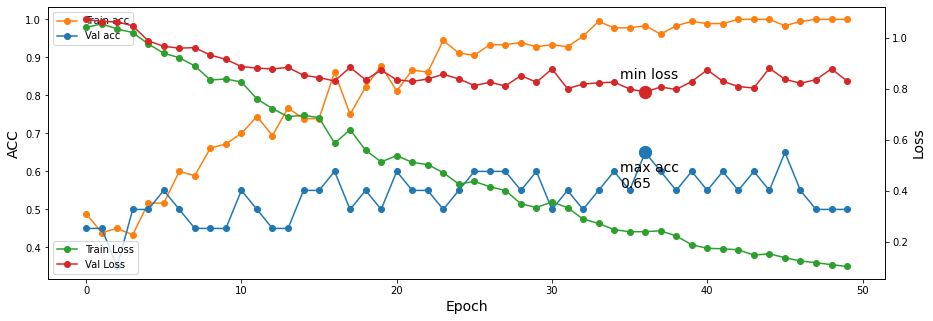

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 13s 290ms/step - loss: 1.0681 - accuracy: 0.4778 - val_loss: 1.0821 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0460 - accuracy: 0.4500 - val_loss: 1.0563 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0450 - accuracy: 0.4222 - val_loss: 1.0523 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0243 - accuracy: 0.4556 - val_loss: 1.0668 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0131 - accuracy: 0.4500 - val_loss: 1.0534 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 91ms/step - loss: 0.9892 - accuracy: 0.4500 - val_loss: 1.0458 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 91ms/step - loss: 0.9597 - accuracy: 0.5278 - val_loss: 1.0512 - val

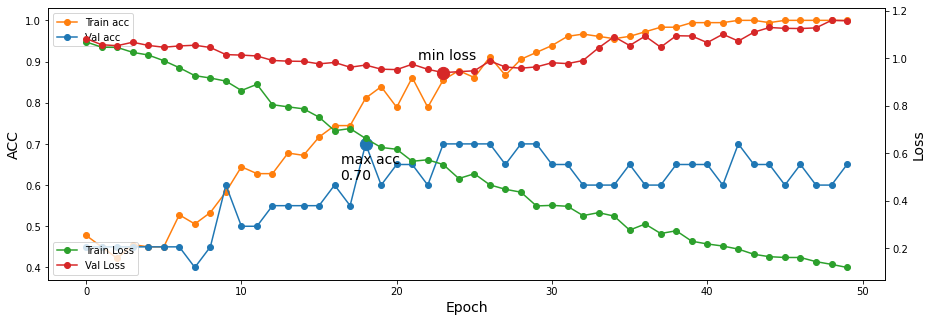

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 13s 291ms/step - loss: 1.0702 - accuracy: 0.4167 - val_loss: 1.0789 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0531 - accuracy: 0.4444 - val_loss: 1.0482 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0491 - accuracy: 0.5056 - val_loss: 1.0417 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0217 - accuracy: 0.4556 - val_loss: 1.0290 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9864 - accuracy: 0.5000 - val_loss: 1.0061 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0064 - accuracy: 0.4722 - val_loss: 0.9847 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9399 - accuracy: 0.5500 - val_loss: 0.9827 - val

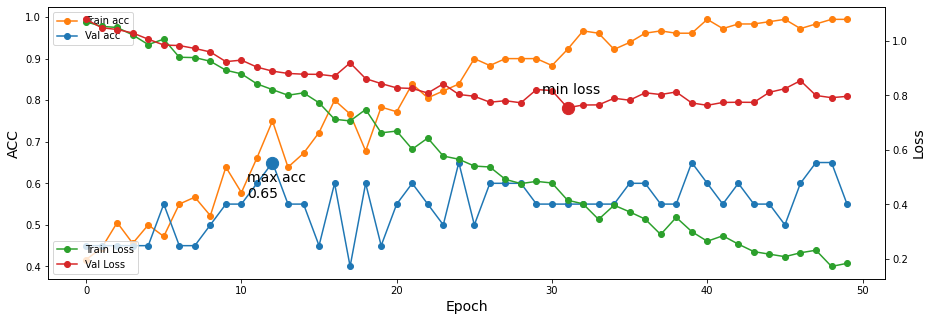

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 12s 274ms/step - loss: 1.0674 - accuracy: 0.4389 - val_loss: 1.0794 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0466 - accuracy: 0.4278 - val_loss: 1.0614 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9830 - accuracy: 0.5167 - val_loss: 1.0569 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9780 - accuracy: 0.5000 - val_loss: 1.0498 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9486 - accuracy: 0.4889 - val_loss: 1.0319 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9373 - accuracy: 0.5111 - val_loss: 1.0164 - val_accuracy: 0.3500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8819 - accuracy: 0.5944 - val_loss: 1.0250 - val

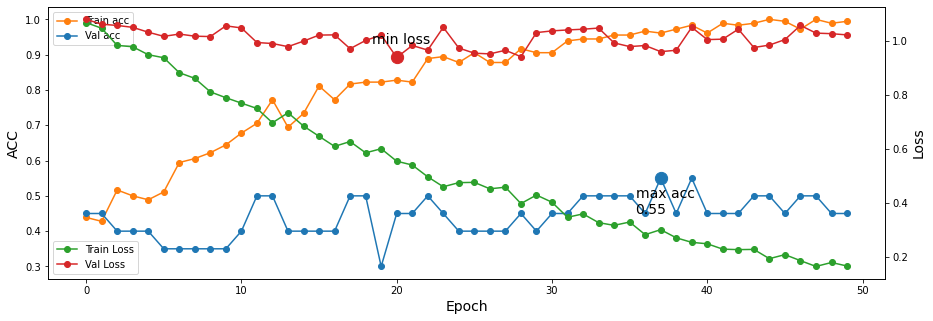

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 13s 287ms/step - loss: 1.0797 - accuracy: 0.4444 - val_loss: 1.0600 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9495 - accuracy: 0.5444 - val_loss: 0.9887 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9245 - accuracy: 0.5778 - val_loss: 0.9649 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8473 - accuracy: 0.6611 - val_loss: 0.9245 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8374 - accuracy: 0.6278 - val_loss: 0.9058 - val_accuracy: 0.7500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.7638 - accuracy: 0.6778 - val_loss: 0.9263 - val_accuracy: 0.7500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.7976 - accuracy: 0.6889 - val_loss: 0.9493 - val

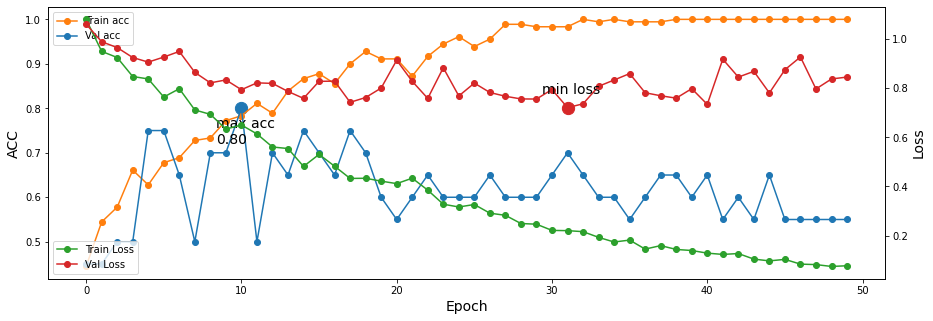

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 13s 288ms/step - loss: 1.0948 - accuracy: 0.3944 - val_loss: 1.0860 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0442 - accuracy: 0.4611 - val_loss: 1.0673 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0331 - accuracy: 0.4556 - val_loss: 1.0935 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0322 - accuracy: 0.4722 - val_loss: 1.0645 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9745 - accuracy: 0.5222 - val_loss: 1.0758 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0320 - accuracy: 0.4556 - val_loss: 1.0752 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9670 - accuracy: 0.5056 - val_loss: 1.0985 - val

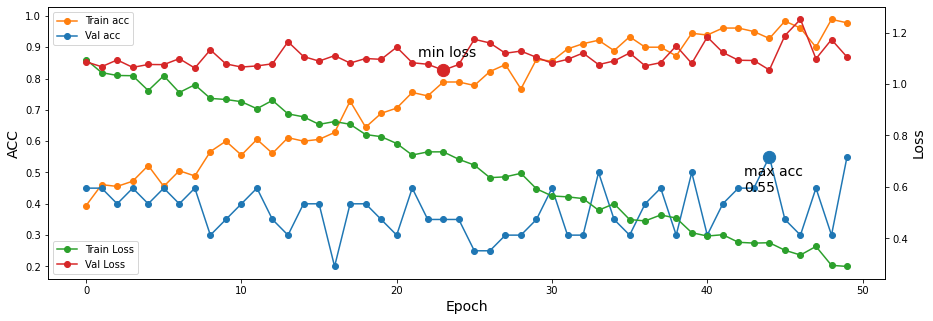

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 12s 270ms/step - loss: 1.0773 - accuracy: 0.4556 - val_loss: 1.0773 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0512 - accuracy: 0.4444 - val_loss: 1.0554 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0609 - accuracy: 0.4222 - val_loss: 1.0555 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0305 - accuracy: 0.4667 - val_loss: 1.0506 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0365 - accuracy: 0.4333 - val_loss: 1.0504 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9986 - accuracy: 0.4722 - val_loss: 1.0369 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9940 - accuracy: 0.4667 - val_loss: 1.0349 - val

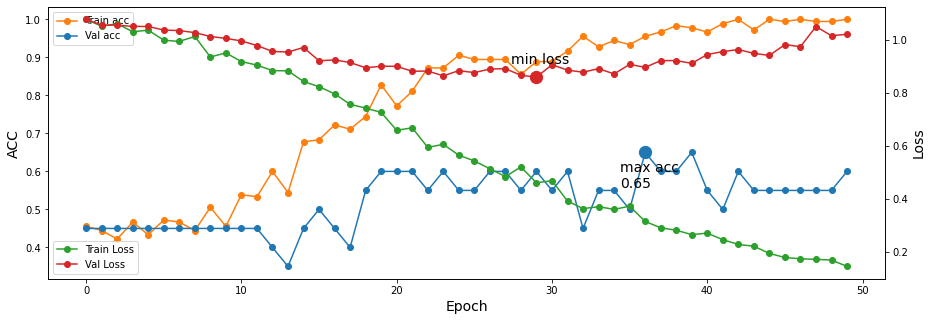

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 13s 289ms/step - loss: 1.0406 - accuracy: 0.4667 - val_loss: 1.0551 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0360 - accuracy: 0.4611 - val_loss: 1.0270 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9762 - accuracy: 0.5000 - val_loss: 1.0199 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9222 - accuracy: 0.5556 - val_loss: 1.0391 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8417 - accuracy: 0.6389 - val_loss: 0.9898 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8500 - accuracy: 0.6278 - val_loss: 0.9988 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.7953 - accuracy: 0.6556 - val_loss: 0.9883 - val

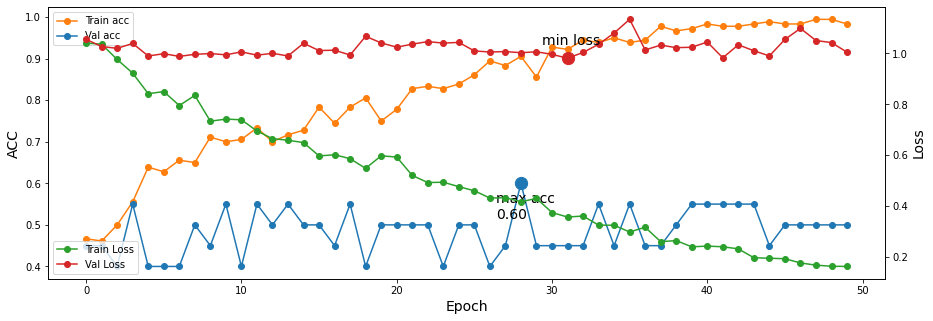

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 13s 292ms/step - loss: 1.0519 - accuracy: 0.4611 - val_loss: 1.0768 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0056 - accuracy: 0.4889 - val_loss: 1.0535 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9819 - accuracy: 0.4722 - val_loss: 1.0158 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9391 - accuracy: 0.5500 - val_loss: 0.9894 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8723 - accuracy: 0.6000 - val_loss: 0.9817 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8379 - accuracy: 0.6000 - val_loss: 0.9505 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.7981 - accuracy: 0.6722 - val_loss: 0.9636 - val

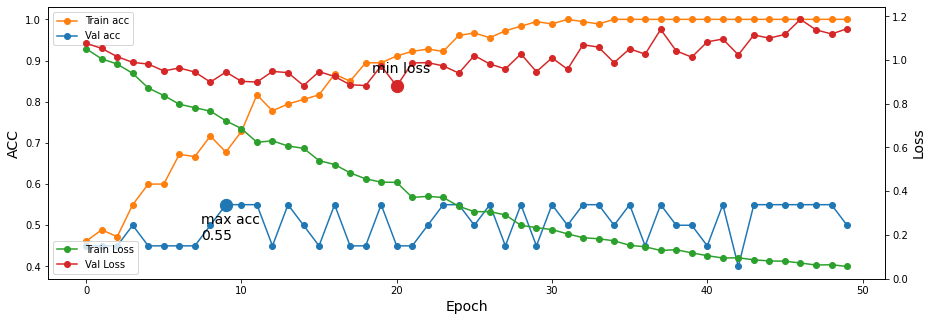

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 12s 276ms/step - loss: 1.0769 - accuracy: 0.4611 - val_loss: 1.0967 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0590 - accuracy: 0.4167 - val_loss: 1.1023 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0316 - accuracy: 0.4611 - val_loss: 1.0831 - val_accuracy: 0.4211
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9959 - accuracy: 0.4944 - val_loss: 1.0631 - val_accuracy: 0.4211
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0006 - accuracy: 0.5278 - val_loss: 1.0495 - val_accuracy: 0.4211
Epoch 6/50
45/45 [==============================] - 4s 91ms/step - loss: 0.9776 - accuracy: 0.4889 - val_loss: 1.0451 - val_accuracy: 0.4737
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9379 - accuracy: 0.5222 - val_loss: 1.0259 - va

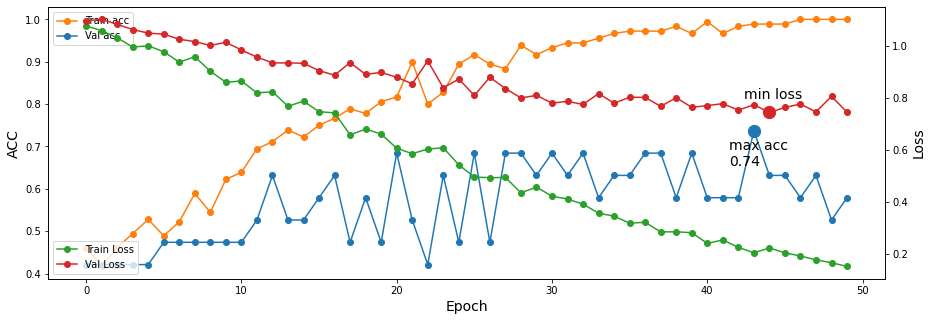

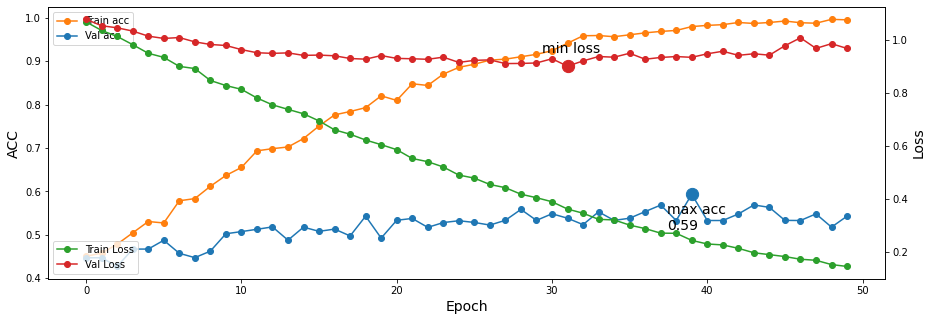

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.10232189297676086 - accuracy: 1.0 - val_loss.: 0.8309211730957031 - val_accuracy: 0.5
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.11972440034151077 - accuracy: 1.0 - val_loss.: 1.1569457054138184 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.1838182657957077 - accuracy: 0.9944444298744202 - val_loss.: 0.7963701486587524 - val_accuracy: 0.550000011920929
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.16638991236686707 - accuracy: 0.9944444298744202 - val_loss.: 1.021845817565918 - val_accuracy: 0.44999998807907104
--------------------------------------------------------------------------------
> Fo

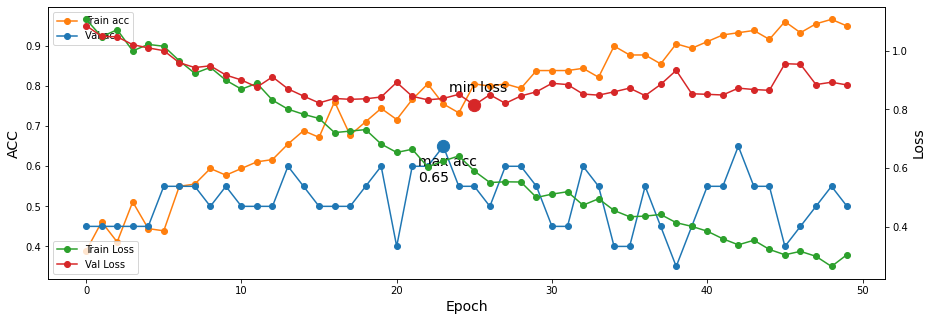

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 13s 291ms/step - loss: 1.0873 - accuracy: 0.4278 - val_loss: 1.0756 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0687 - accuracy: 0.4444 - val_loss: 1.0546 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0609 - accuracy: 0.4389 - val_loss: 1.0569 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0163 - accuracy: 0.4833 - val_loss: 1.0527 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9967 - accuracy: 0.5167 - val_loss: 1.0336 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9515 - accuracy: 0.5611 - val_loss: 1.0541 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9899 - accuracy: 0.4944 - val_loss: 1.0231 - val

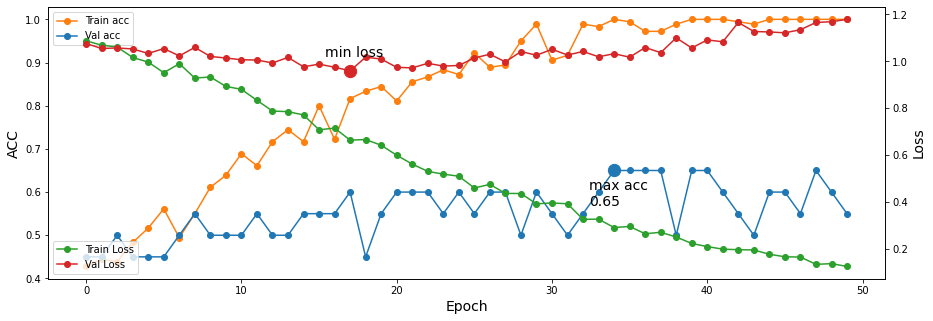

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 13s 297ms/step - loss: 1.1186 - accuracy: 0.4167 - val_loss: 1.0780 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0787 - accuracy: 0.4111 - val_loss: 1.0473 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0277 - accuracy: 0.4944 - val_loss: 1.0425 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0394 - accuracy: 0.4278 - val_loss: 1.0230 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0150 - accuracy: 0.4833 - val_loss: 1.0136 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9887 - accuracy: 0.4944 - val_loss: 1.0105 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 4s 96ms/step - loss: 0.9626 - accuracy: 0.5333 - val_loss: 1.0083 - val

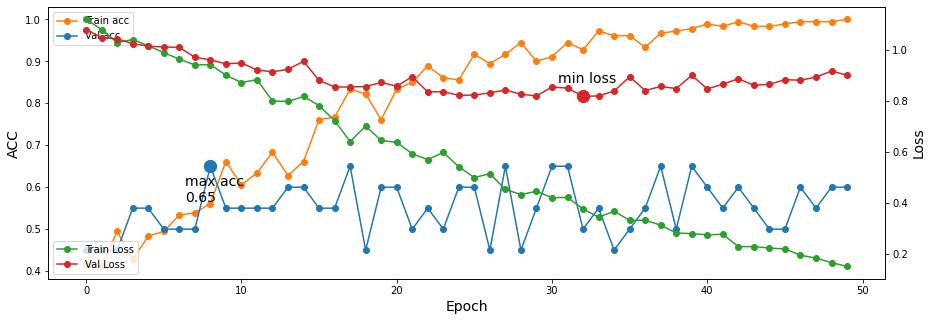

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 13s 291ms/step - loss: 1.0820 - accuracy: 0.4389 - val_loss: 1.0884 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0401 - accuracy: 0.4778 - val_loss: 1.0807 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 91ms/step - loss: 1.0370 - accuracy: 0.4056 - val_loss: 1.0878 - val_accuracy: 0.3500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9904 - accuracy: 0.5611 - val_loss: 1.0859 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9749 - accuracy: 0.4722 - val_loss: 1.0552 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9572 - accuracy: 0.5111 - val_loss: 1.0770 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9089 - accuracy: 0.5500 - val_loss: 1.0608 - val

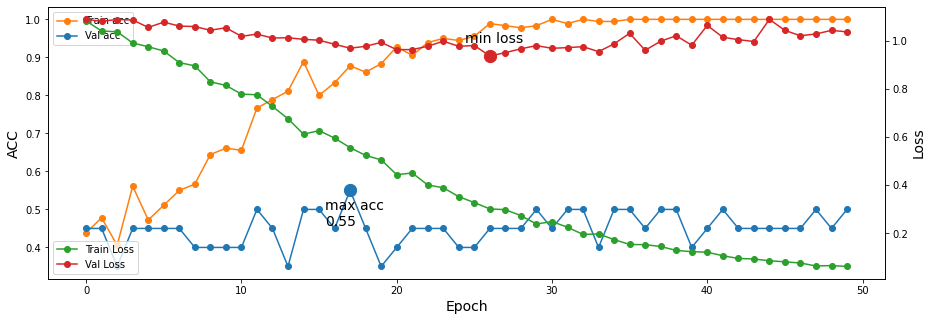

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 13s 292ms/step - loss: 1.0379 - accuracy: 0.4222 - val_loss: 1.0438 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9965 - accuracy: 0.4389 - val_loss: 0.9741 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9275 - accuracy: 0.5278 - val_loss: 0.9503 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9023 - accuracy: 0.5889 - val_loss: 0.8917 - val_accuracy: 0.6000
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8422 - accuracy: 0.6444 - val_loss: 0.9392 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8125 - accuracy: 0.6278 - val_loss: 0.8529 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.7746 - accuracy: 0.7278 - val_loss: 0.8598 - val

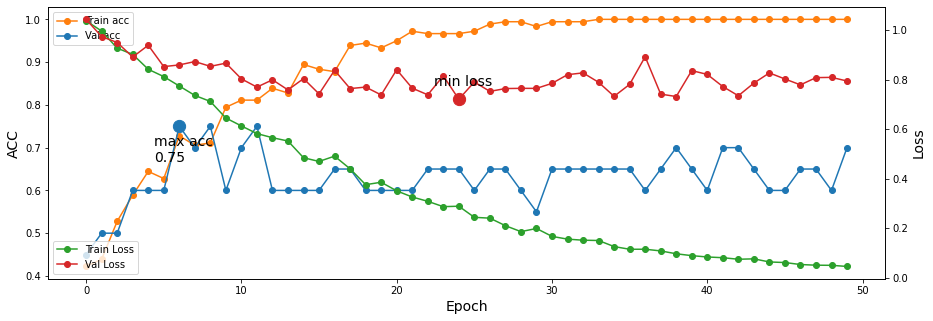

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 13s 293ms/step - loss: 1.0516 - accuracy: 0.4778 - val_loss: 1.0741 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0402 - accuracy: 0.4667 - val_loss: 1.0372 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0296 - accuracy: 0.4833 - val_loss: 1.0148 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9927 - accuracy: 0.5222 - val_loss: 1.0113 - val_accuracy: 0.6500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9303 - accuracy: 0.5722 - val_loss: 0.9766 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9134 - accuracy: 0.5778 - val_loss: 0.9532 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8884 - accuracy: 0.6056 - val_loss: 0.9386 - val

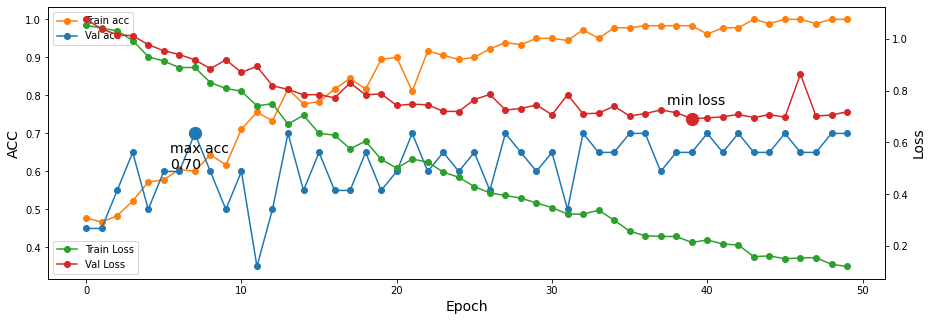

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 13s 289ms/step - loss: 1.0668 - accuracy: 0.4222 - val_loss: 1.0747 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0319 - accuracy: 0.4500 - val_loss: 1.0430 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0153 - accuracy: 0.5111 - val_loss: 1.0298 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9648 - accuracy: 0.5000 - val_loss: 1.0107 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9323 - accuracy: 0.5278 - val_loss: 0.9992 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8953 - accuracy: 0.5222 - val_loss: 0.9620 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8753 - accuracy: 0.5833 - val_loss: 0.9398 - val

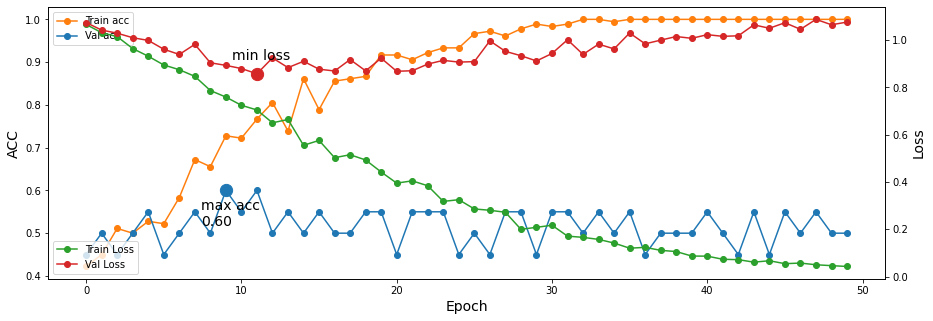

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 13s 293ms/step - loss: 1.0549 - accuracy: 0.4556 - val_loss: 1.0754 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0544 - accuracy: 0.4333 - val_loss: 1.0763 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0249 - accuracy: 0.4611 - val_loss: 1.0686 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9852 - accuracy: 0.4833 - val_loss: 1.0692 - val_accuracy: 0.3500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9570 - accuracy: 0.5722 - val_loss: 1.0495 - val_accuracy: 0.3500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9393 - accuracy: 0.6167 - val_loss: 1.0471 - val_accuracy: 0.3500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8862 - accuracy: 0.5556 - val_loss: 1.0565 - val

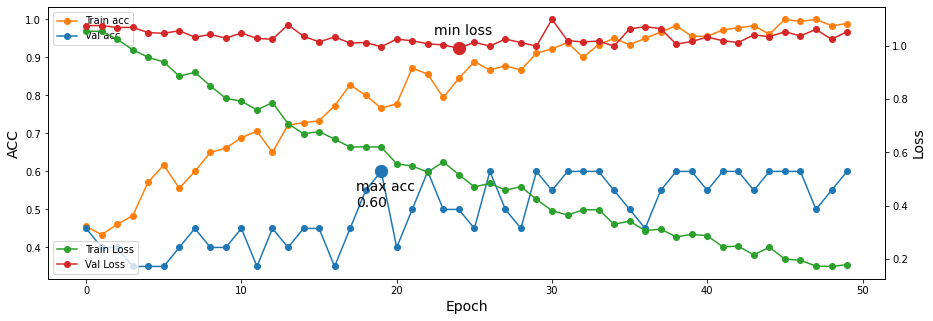

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 13s 292ms/step - loss: 1.0745 - accuracy: 0.4611 - val_loss: 1.0853 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0485 - accuracy: 0.4500 - val_loss: 1.0736 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0234 - accuracy: 0.4611 - val_loss: 1.0668 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0239 - accuracy: 0.4778 - val_loss: 1.0450 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9891 - accuracy: 0.4944 - val_loss: 1.0418 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9547 - accuracy: 0.5111 - val_loss: 1.0220 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9167 - accuracy: 0.5389 - val_loss: 1.0000 - val

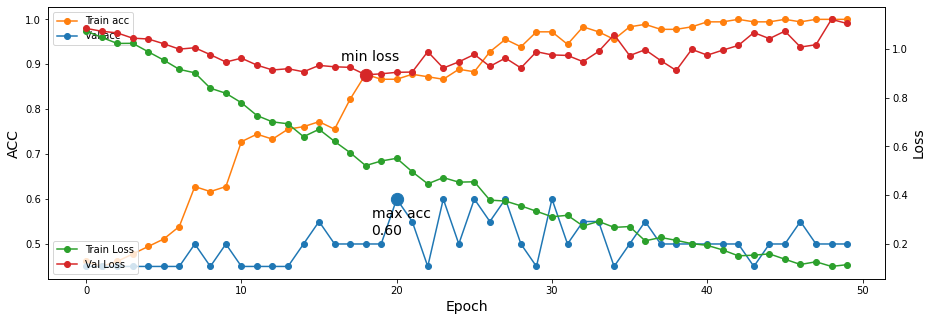

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 13s 290ms/step - loss: 1.0903 - accuracy: 0.3111 - val_loss: 1.0896 - val_accuracy: 0.6316
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0812 - accuracy: 0.4333 - val_loss: 1.0682 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0592 - accuracy: 0.4611 - val_loss: 1.0570 - val_accuracy: 0.4211
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0250 - accuracy: 0.5111 - val_loss: 1.0529 - val_accuracy: 0.4211
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0291 - accuracy: 0.4444 - val_loss: 1.0465 - val_accuracy: 0.4211
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0058 - accuracy: 0.4722 - val_loss: 1.0348 - val_accuracy: 0.4211
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0091 - accuracy: 0.4333 - val_loss: 1.0220 - va

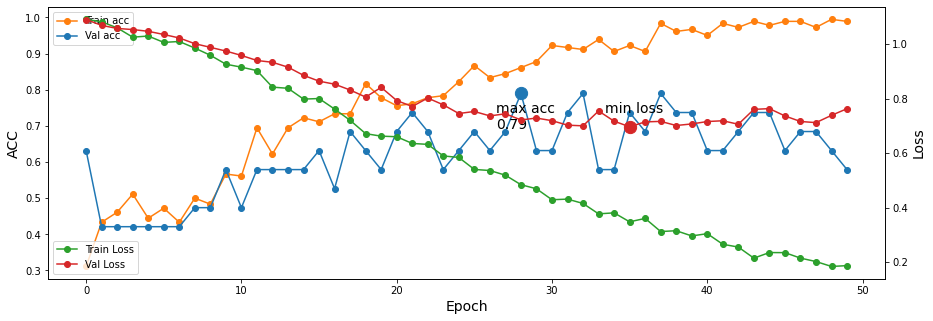

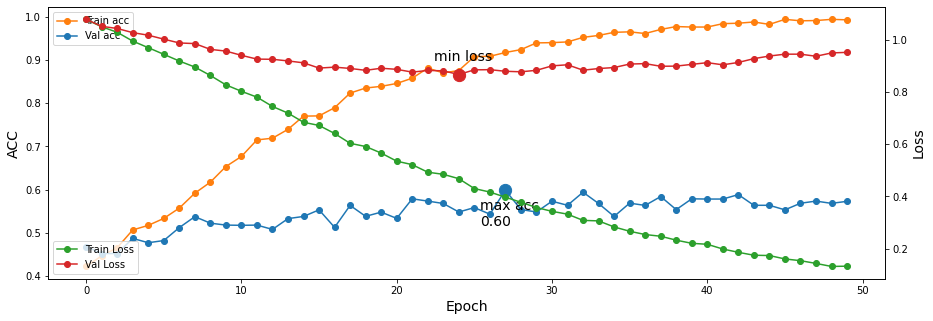

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.3045029044151306 - accuracy: 0.949999988079071 - val_loss.: 0.8831495046615601 - val_accuracy: 0.5
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.12639839947223663 - accuracy: 1.0 - val_loss.: 1.1787089109420776 - val_accuracy: 0.550000011920929
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.15077871084213257 - accuracy: 1.0 - val_loss.: 0.8999185562133789 - val_accuracy: 0.6000000238418579
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.06250737607479095 - accuracy: 1.0 - val_loss.: 1.0366709232330322 - val_accuracy: 0.5
--------------------------------------------------------------------------------
> Fold 5 - loss: 0.0459472872316837

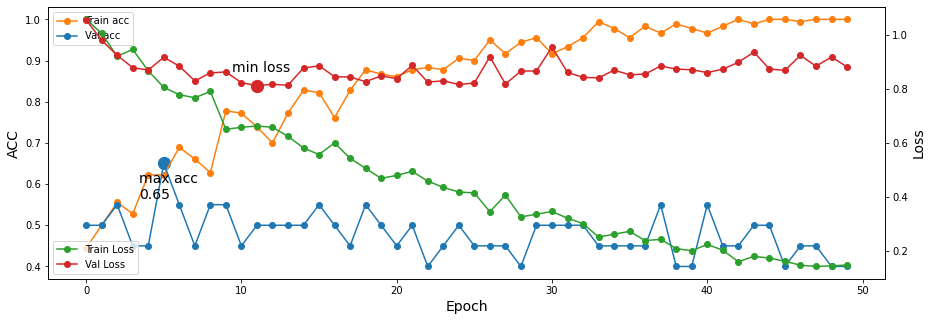

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 13s 280ms/step - loss: 1.0783 - accuracy: 0.4111 - val_loss: 1.0673 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9756 - accuracy: 0.5333 - val_loss: 1.0416 - val_accuracy: 0.5500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9755 - accuracy: 0.5722 - val_loss: 0.9595 - val_accuracy: 0.6500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9143 - accuracy: 0.6389 - val_loss: 0.9744 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8799 - accuracy: 0.5667 - val_loss: 0.9616 - val_accuracy: 0.7000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8209 - accuracy: 0.6389 - val_loss: 0.9610 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8088 - accuracy: 0.6889 - val_loss: 0.9329 - val

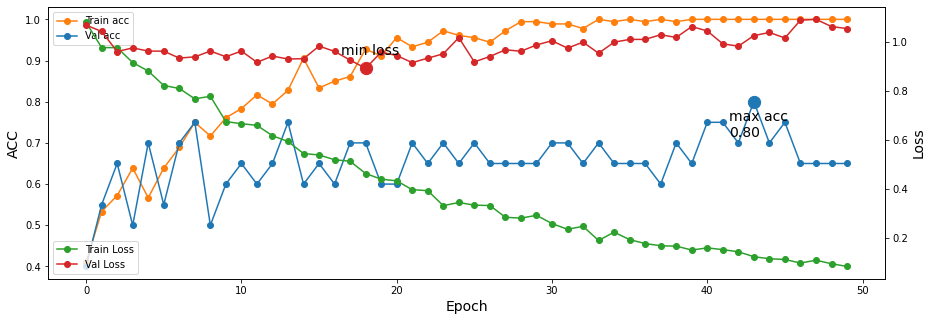

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 13s 289ms/step - loss: 1.0773 - accuracy: 0.4056 - val_loss: 1.0829 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0740 - accuracy: 0.4167 - val_loss: 1.0645 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0513 - accuracy: 0.4389 - val_loss: 1.0642 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0318 - accuracy: 0.4722 - val_loss: 1.0414 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0322 - accuracy: 0.4222 - val_loss: 1.0339 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0135 - accuracy: 0.4611 - val_loss: 1.0194 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9886 - accuracy: 0.5056 - val_loss: 1.0055 - val

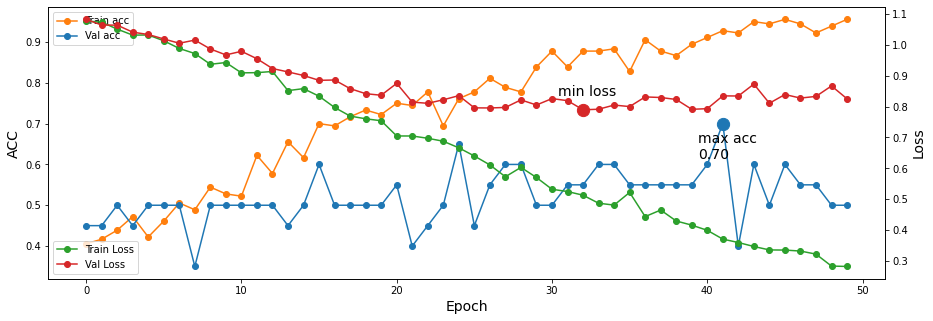

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 13s 290ms/step - loss: 1.0835 - accuracy: 0.4056 - val_loss: 1.0812 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0619 - accuracy: 0.4722 - val_loss: 1.0682 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0512 - accuracy: 0.4556 - val_loss: 1.0757 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0314 - accuracy: 0.4778 - val_loss: 1.0860 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0068 - accuracy: 0.4833 - val_loss: 1.0727 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0291 - accuracy: 0.5222 - val_loss: 1.0758 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0219 - accuracy: 0.4889 - val_loss: 1.0719 - val

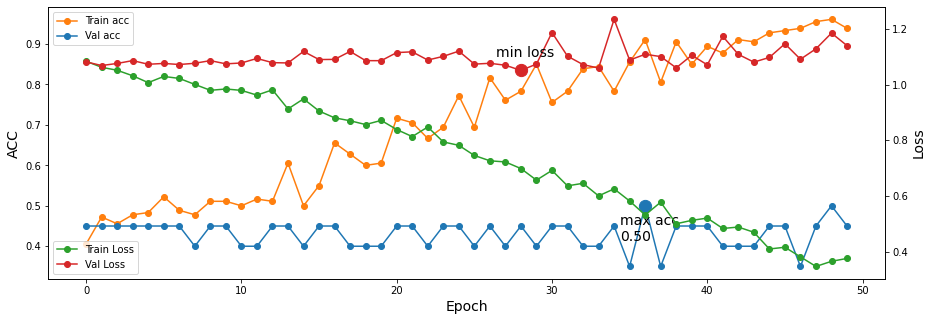

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 13s 289ms/step - loss: 1.0619 - accuracy: 0.4333 - val_loss: 1.0785 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0089 - accuracy: 0.4944 - val_loss: 1.0379 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9875 - accuracy: 0.5111 - val_loss: 1.0207 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9555 - accuracy: 0.5500 - val_loss: 1.0160 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9232 - accuracy: 0.5389 - val_loss: 0.9853 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8938 - accuracy: 0.5722 - val_loss: 1.0179 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8649 - accuracy: 0.6333 - val_loss: 0.9722 - val

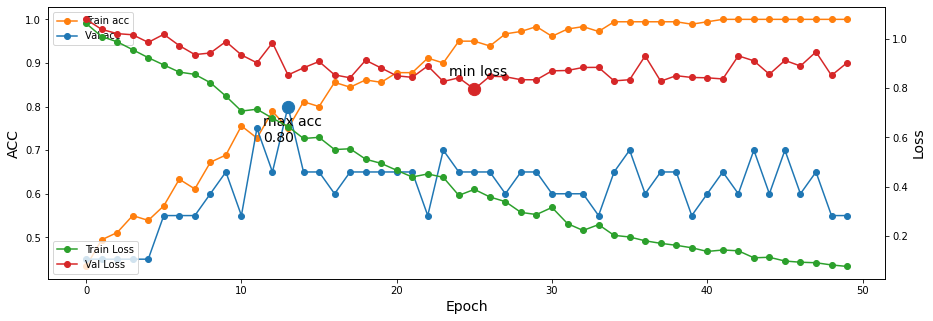

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 13s 292ms/step - loss: 1.1659 - accuracy: 0.3722 - val_loss: 1.0832 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0487 - accuracy: 0.4500 - val_loss: 1.0881 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0494 - accuracy: 0.4833 - val_loss: 1.0949 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0392 - accuracy: 0.4722 - val_loss: 1.1056 - val_accuracy: 0.2500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0242 - accuracy: 0.5000 - val_loss: 1.1120 - val_accuracy: 0.3500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0010 - accuracy: 0.5722 - val_loss: 1.0764 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9806 - accuracy: 0.5278 - val_loss: 1.0784 - val

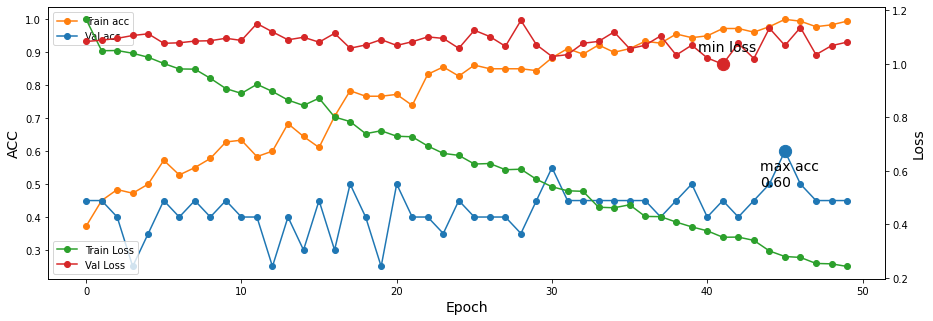

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 13s 288ms/step - loss: 1.0840 - accuracy: 0.4444 - val_loss: 1.0803 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0374 - accuracy: 0.4556 - val_loss: 1.0408 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9990 - accuracy: 0.5056 - val_loss: 1.0220 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9782 - accuracy: 0.4722 - val_loss: 0.9849 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9405 - accuracy: 0.5667 - val_loss: 0.9790 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8737 - accuracy: 0.5833 - val_loss: 0.9256 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8757 - accuracy: 0.6000 - val_loss: 0.9283 - val

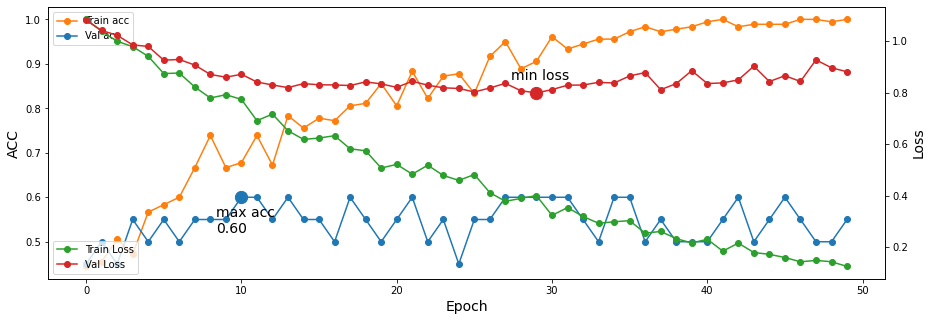

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 14s 307ms/step - loss: 1.0857 - accuracy: 0.4222 - val_loss: 1.0890 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0441 - accuracy: 0.4667 - val_loss: 1.0781 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0450 - accuracy: 0.4333 - val_loss: 1.0707 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9979 - accuracy: 0.5111 - val_loss: 1.0706 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9850 - accuracy: 0.4778 - val_loss: 1.0710 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9711 - accuracy: 0.4889 - val_loss: 1.0635 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9156 - accuracy: 0.5722 - val_loss: 1.0621 - val

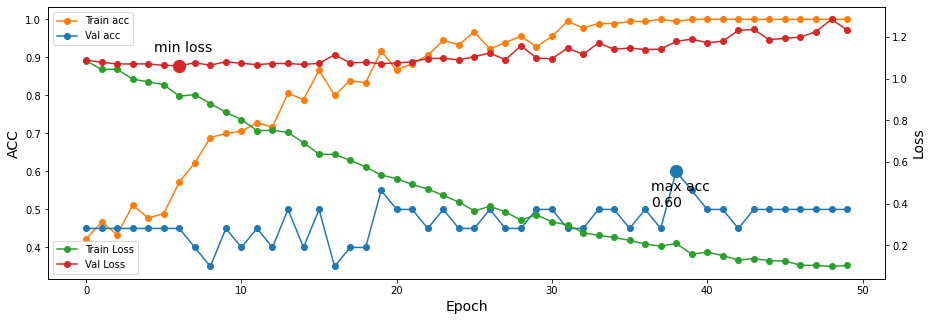

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 13s 288ms/step - loss: 0.9973 - accuracy: 0.5000 - val_loss: 1.0327 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9428 - accuracy: 0.5556 - val_loss: 0.9638 - val_accuracy: 0.5500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9083 - accuracy: 0.5556 - val_loss: 0.9627 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8739 - accuracy: 0.6000 - val_loss: 0.9374 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8406 - accuracy: 0.6444 - val_loss: 0.9055 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.7846 - accuracy: 0.6333 - val_loss: 0.9511 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8187 - accuracy: 0.6111 - val_loss: 0.8763 - val

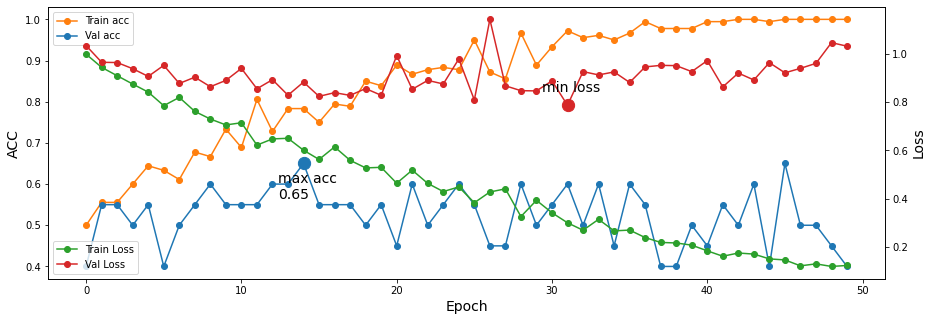

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 13s 289ms/step - loss: 1.0753 - accuracy: 0.4056 - val_loss: 1.0815 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9945 - accuracy: 0.4889 - val_loss: 1.0594 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9992 - accuracy: 0.4889 - val_loss: 1.0329 - val_accuracy: 0.3158
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9679 - accuracy: 0.5222 - val_loss: 1.0105 - val_accuracy: 0.4211
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9436 - accuracy: 0.5444 - val_loss: 0.9861 - val_accuracy: 0.4211
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9025 - accuracy: 0.6444 - val_loss: 0.9470 - val_accuracy: 0.4211
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9251 - accuracy: 0.5278 - val_loss: 0.9287 - va

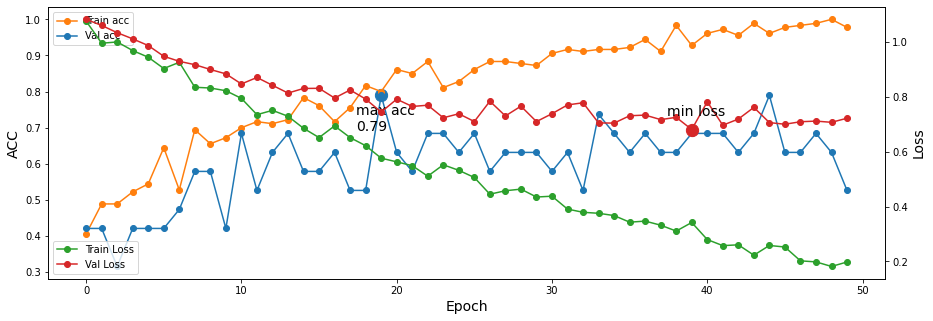

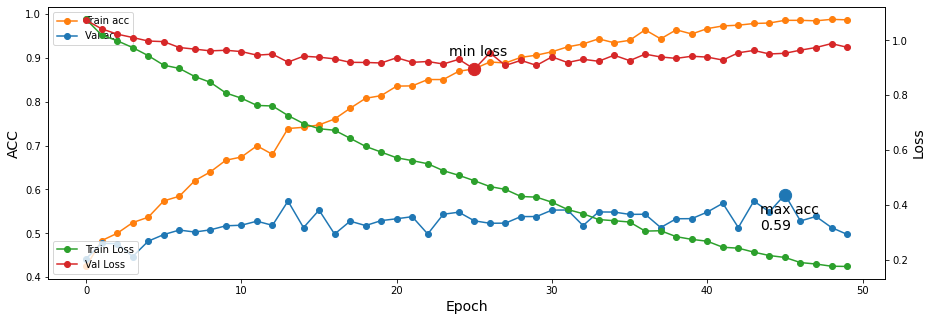

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.14706498384475708 - accuracy: 1.0 - val_loss.: 0.8809602856636047 - val_accuracy: 0.4000000059604645
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.08189473301172256 - accuracy: 1.0 - val_loss.: 1.0533690452575684 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.2818150520324707 - accuracy: 0.9555555582046509 - val_loss.: 0.8253740072250366 - val_accuracy: 0.5
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.37547174096107483 - accuracy: 0.9388889074325562 - val_loss.: 1.1396690607070923 - val_accuracy: 0.44999998807907104
--------------------------------------------------------------------------------
> 

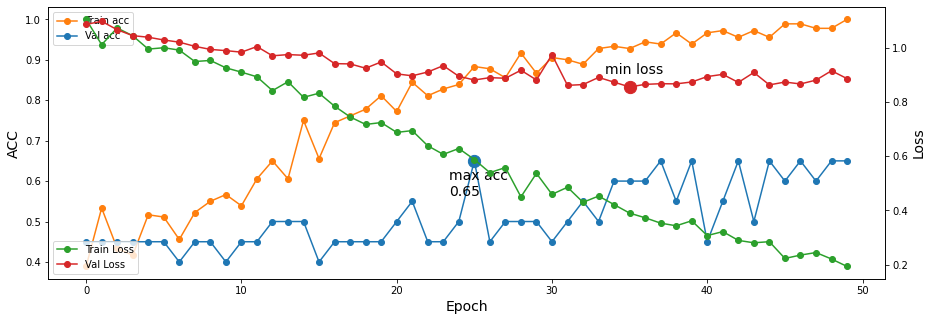

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 13s 289ms/step - loss: 1.0917 - accuracy: 0.4222 - val_loss: 1.0617 - val_accuracy: 0.5500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0109 - accuracy: 0.5222 - val_loss: 1.0416 - val_accuracy: 0.5500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9213 - accuracy: 0.5778 - val_loss: 1.0053 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8299 - accuracy: 0.6500 - val_loss: 1.0018 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8623 - accuracy: 0.5944 - val_loss: 1.0066 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8028 - accuracy: 0.6278 - val_loss: 1.0731 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.7224 - accuracy: 0.6833 - val_loss: 0.9593 - val

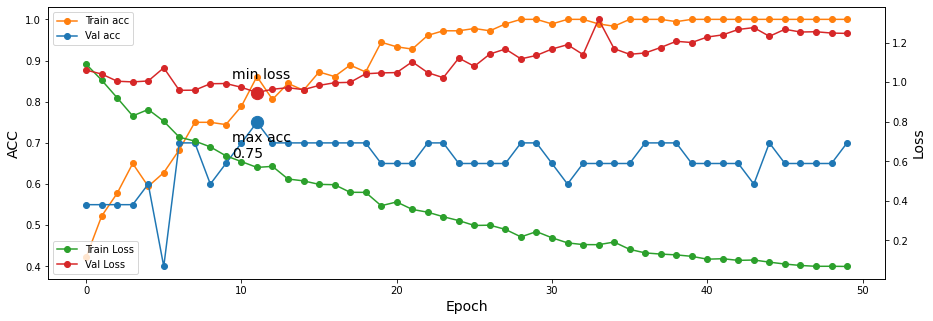

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 13s 288ms/step - loss: 1.0881 - accuracy: 0.4056 - val_loss: 1.0688 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0515 - accuracy: 0.4444 - val_loss: 0.9916 - val_accuracy: 0.6000
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9785 - accuracy: 0.5667 - val_loss: 0.9414 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9243 - accuracy: 0.5611 - val_loss: 0.9154 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9099 - accuracy: 0.5556 - val_loss: 0.9251 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8993 - accuracy: 0.5556 - val_loss: 0.8748 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8295 - accuracy: 0.6667 - val_loss: 0.8581 - val

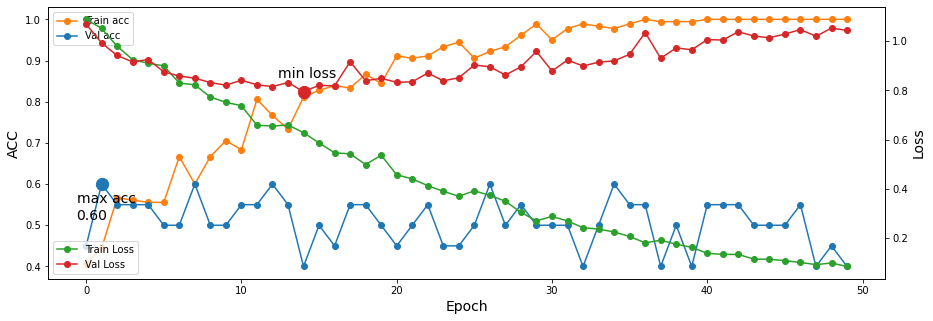

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 13s 288ms/step - loss: 1.0887 - accuracy: 0.3889 - val_loss: 1.0839 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0614 - accuracy: 0.4222 - val_loss: 1.0649 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0222 - accuracy: 0.4722 - val_loss: 1.0425 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9833 - accuracy: 0.4833 - val_loss: 1.0336 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9638 - accuracy: 0.5111 - val_loss: 1.0362 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9427 - accuracy: 0.5222 - val_loss: 1.0097 - val_accuracy: 0.2500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8760 - accuracy: 0.6444 - val_loss: 0.9914 - val

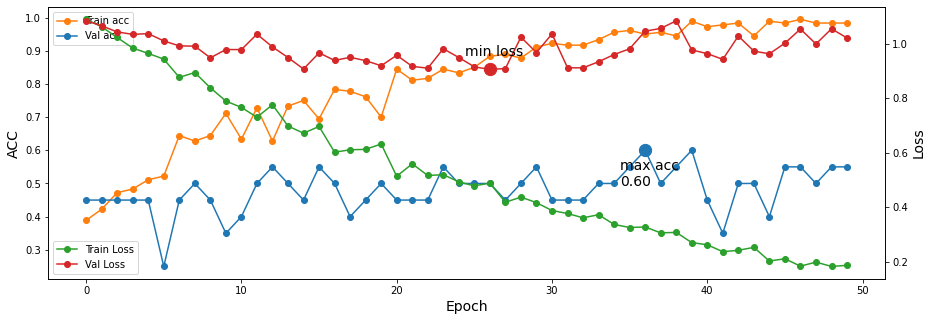

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 13s 292ms/step - loss: 1.0932 - accuracy: 0.3833 - val_loss: 1.0806 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0513 - accuracy: 0.4611 - val_loss: 1.0533 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0352 - accuracy: 0.4722 - val_loss: 1.0429 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0370 - accuracy: 0.4500 - val_loss: 1.0393 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9891 - accuracy: 0.5000 - val_loss: 1.0301 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9966 - accuracy: 0.4889 - val_loss: 1.0267 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0012 - accuracy: 0.5611 - val_loss: 1.0176 - val

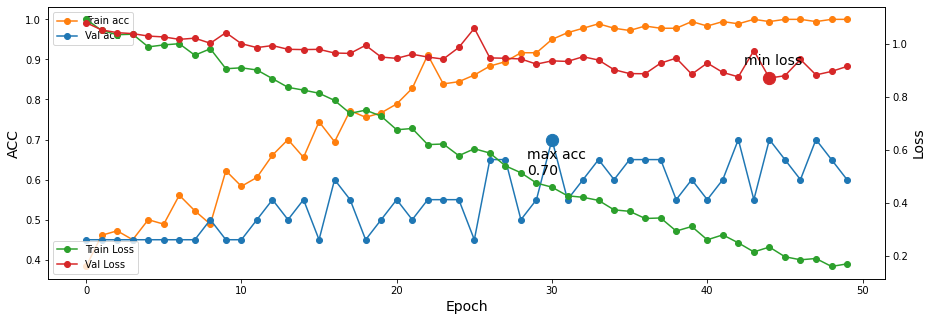

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 12s 268ms/step - loss: 1.0741 - accuracy: 0.4278 - val_loss: 1.0812 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0759 - accuracy: 0.3889 - val_loss: 1.0577 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0253 - accuracy: 0.4944 - val_loss: 1.0270 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0162 - accuracy: 0.4556 - val_loss: 1.0209 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9968 - accuracy: 0.4722 - val_loss: 0.9994 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9720 - accuracy: 0.4889 - val_loss: 0.9657 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9564 - accuracy: 0.4833 - val_loss: 0.9447 - val

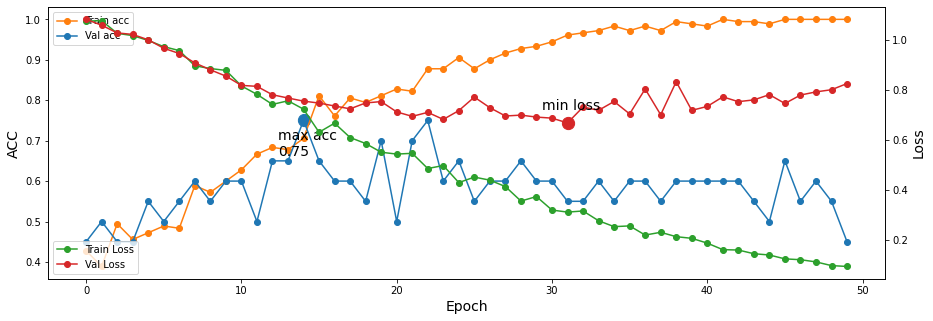

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 12s 268ms/step - loss: 1.0608 - accuracy: 0.4500 - val_loss: 1.0613 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0198 - accuracy: 0.4611 - val_loss: 1.0089 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9749 - accuracy: 0.4722 - val_loss: 0.9494 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8927 - accuracy: 0.5833 - val_loss: 0.9450 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9226 - accuracy: 0.6111 - val_loss: 0.9159 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8605 - accuracy: 0.6444 - val_loss: 0.9583 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8249 - accuracy: 0.6278 - val_loss: 0.8618 - val

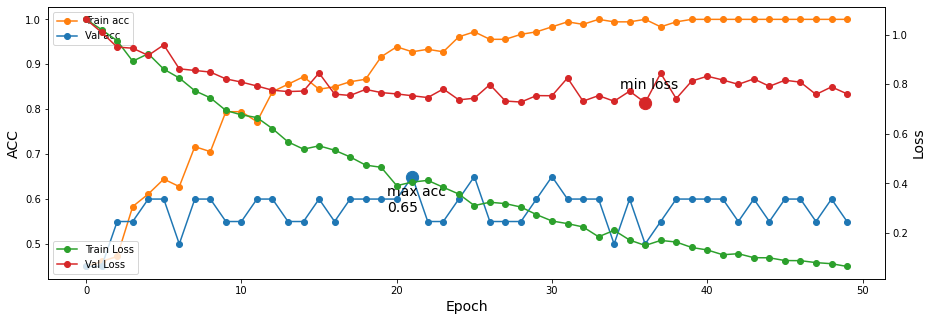

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 13s 292ms/step - loss: 1.0324 - accuracy: 0.4833 - val_loss: 1.0552 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9577 - accuracy: 0.5167 - val_loss: 1.0375 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9354 - accuracy: 0.5833 - val_loss: 1.0176 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9012 - accuracy: 0.5389 - val_loss: 1.0023 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8399 - accuracy: 0.6500 - val_loss: 0.9898 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8143 - accuracy: 0.6722 - val_loss: 0.9810 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.7908 - accuracy: 0.6833 - val_loss: 1.0236 - val

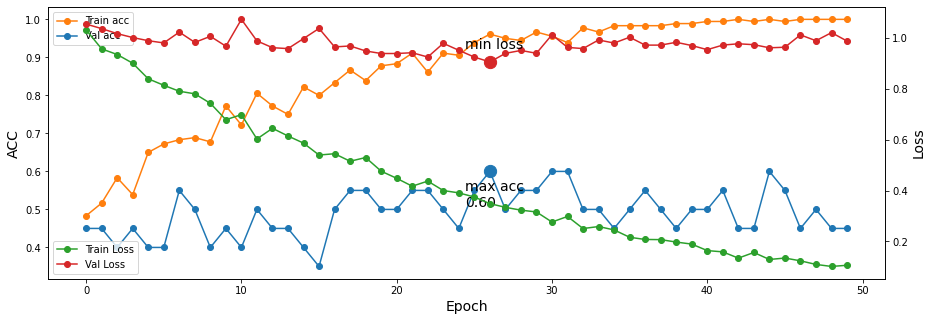

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 12s 268ms/step - loss: 1.0419 - accuracy: 0.4889 - val_loss: 1.0647 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0003 - accuracy: 0.4833 - val_loss: 1.0452 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9869 - accuracy: 0.5722 - val_loss: 0.9913 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9341 - accuracy: 0.5944 - val_loss: 0.9860 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8538 - accuracy: 0.6500 - val_loss: 0.9731 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8772 - accuracy: 0.5833 - val_loss: 0.9450 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8476 - accuracy: 0.6389 - val_loss: 0.9405 - val

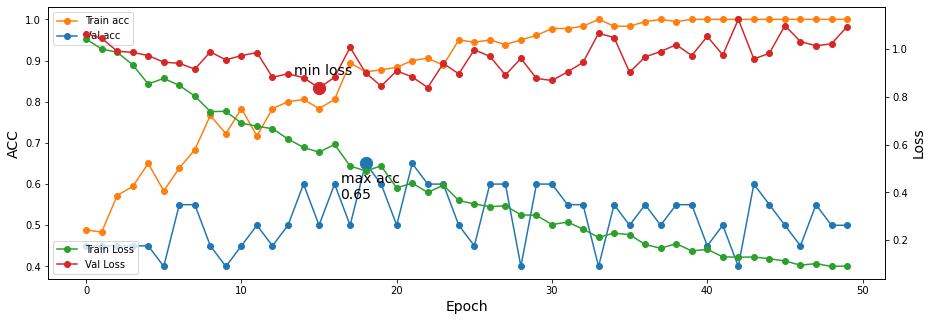

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 13s 293ms/step - loss: 1.0330 - accuracy: 0.4944 - val_loss: 1.0589 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0302 - accuracy: 0.4444 - val_loss: 0.9991 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9713 - accuracy: 0.5222 - val_loss: 0.9707 - val_accuracy: 0.5263
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8955 - accuracy: 0.5944 - val_loss: 0.9269 - val_accuracy: 0.5263
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8622 - accuracy: 0.5889 - val_loss: 0.9112 - val_accuracy: 0.6842
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.7876 - accuracy: 0.6278 - val_loss: 0.8689 - val_accuracy: 0.5789
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8115 - accuracy: 0.6611 - val_loss: 0.8369 - va

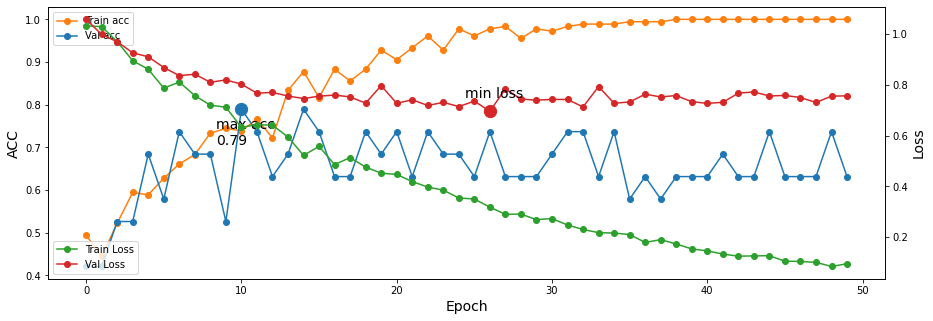

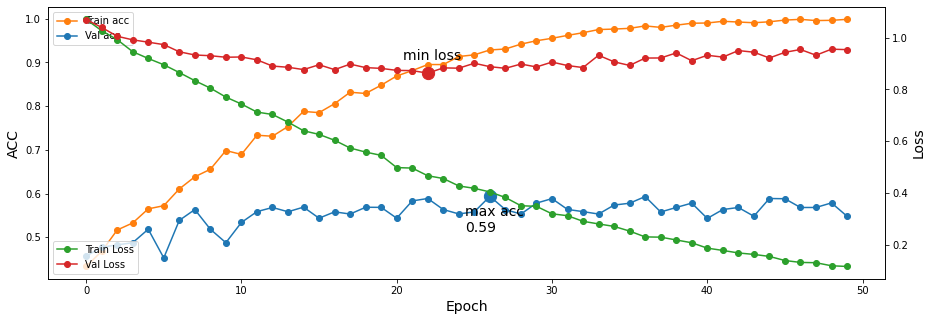

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.1935557723045349 - accuracy: 1.0 - val_loss.: 0.8864732980728149 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.06882145255804062 - accuracy: 1.0 - val_loss.: 1.247005581855774 - val_accuracy: 0.699999988079071
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.08491825312376022 - accuracy: 1.0 - val_loss.: 1.0432922840118408 - val_accuracy: 0.4000000059604645
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.18654701113700867 - accuracy: 0.9833333492279053 - val_loss.: 1.0204105377197266 - val_accuracy: 0.550000011920929
--------------------------------------------------------------------------------
> Fold

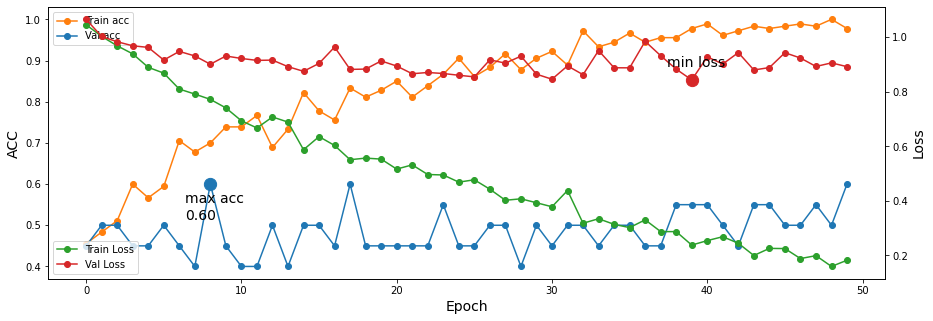

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 13s 294ms/step - loss: 1.0234 - accuracy: 0.5111 - val_loss: 1.0747 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9850 - accuracy: 0.5111 - val_loss: 1.0360 - val_accuracy: 0.6000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9419 - accuracy: 0.5000 - val_loss: 1.0199 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9348 - accuracy: 0.5167 - val_loss: 1.0285 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8429 - accuracy: 0.6444 - val_loss: 1.0190 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 4s 92ms/step - loss: 0.7933 - accuracy: 0.6444 - val_loss: 1.0509 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.7979 - accuracy: 0.6611 - val_loss: 0.9996 - val

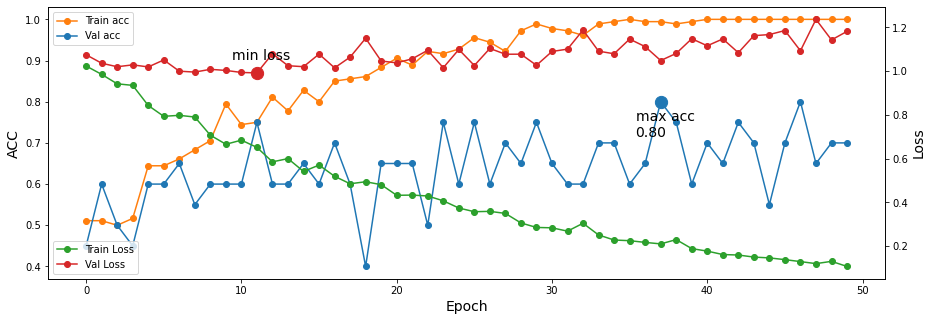

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 13s 289ms/step - loss: 1.0489 - accuracy: 0.4611 - val_loss: 1.0652 - val_accuracy: 0.5500
Epoch 2/50
45/45 [==============================] - 4s 94ms/step - loss: 1.0169 - accuracy: 0.4833 - val_loss: 0.9970 - val_accuracy: 0.5500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9260 - accuracy: 0.5833 - val_loss: 0.9808 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9242 - accuracy: 0.5611 - val_loss: 0.9508 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.7980 - accuracy: 0.7222 - val_loss: 0.9444 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8533 - accuracy: 0.6111 - val_loss: 0.8772 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 4s 94ms/step - loss: 0.8033 - accuracy: 0.6556 - val_loss: 0.8788 - val

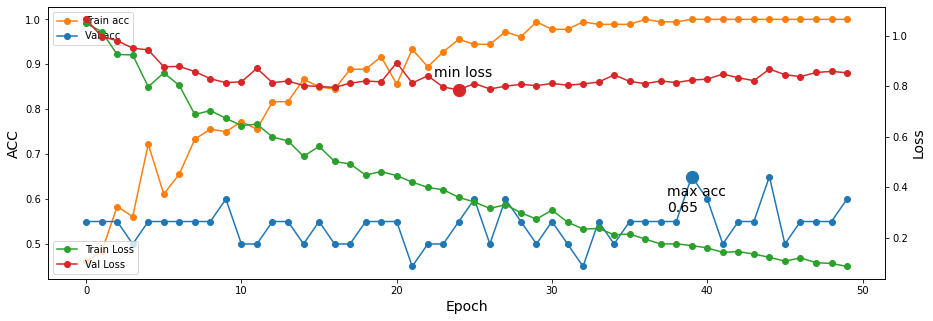

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 13s 293ms/step - loss: 1.0591 - accuracy: 0.4278 - val_loss: 1.0554 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9799 - accuracy: 0.5167 - val_loss: 1.0084 - val_accuracy: 0.3500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8896 - accuracy: 0.5722 - val_loss: 1.0137 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8321 - accuracy: 0.6000 - val_loss: 0.9938 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8694 - accuracy: 0.5778 - val_loss: 0.9944 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8010 - accuracy: 0.6167 - val_loss: 1.0739 - val_accuracy: 0.3500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8241 - accuracy: 0.6556 - val_loss: 0.9813 - val

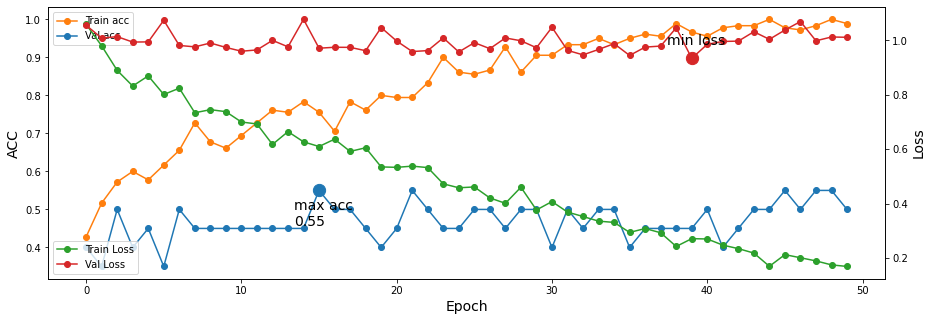

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 13s 288ms/step - loss: 1.0826 - accuracy: 0.4278 - val_loss: 1.0647 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0293 - accuracy: 0.4278 - val_loss: 1.0187 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9972 - accuracy: 0.5000 - val_loss: 0.9872 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9218 - accuracy: 0.5333 - val_loss: 1.0062 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9585 - accuracy: 0.5500 - val_loss: 0.9620 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 4s 94ms/step - loss: 0.8960 - accuracy: 0.5778 - val_loss: 0.9285 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8652 - accuracy: 0.7056 - val_loss: 0.9164 - val

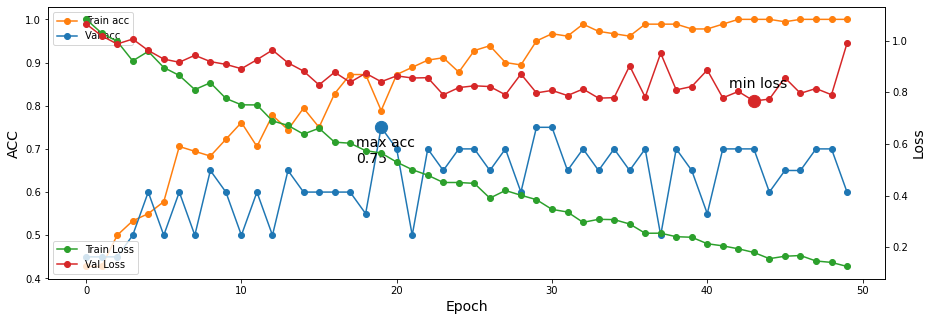

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 12s 266ms/step - loss: 1.0329 - accuracy: 0.4889 - val_loss: 1.0689 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0610 - accuracy: 0.4111 - val_loss: 1.0333 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0109 - accuracy: 0.5000 - val_loss: 1.0127 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9470 - accuracy: 0.5889 - val_loss: 0.9848 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9329 - accuracy: 0.4889 - val_loss: 0.9697 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8866 - accuracy: 0.5778 - val_loss: 1.0082 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9039 - accuracy: 0.6167 - val_loss: 0.9316 - val

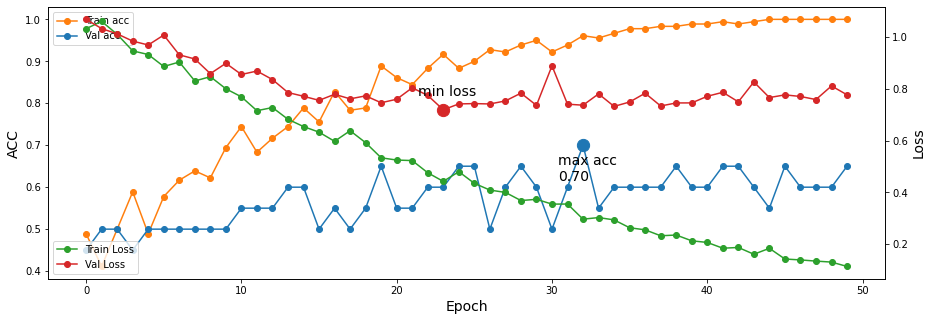

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 13s 293ms/step - loss: 1.0863 - accuracy: 0.3667 - val_loss: 1.0736 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0503 - accuracy: 0.4333 - val_loss: 1.0485 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9811 - accuracy: 0.5278 - val_loss: 1.0332 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 1.0060 - accuracy: 0.5278 - val_loss: 1.0027 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9132 - accuracy: 0.5444 - val_loss: 0.9936 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9275 - accuracy: 0.5722 - val_loss: 0.9624 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8917 - accuracy: 0.5944 - val_loss: 0.9575 - val

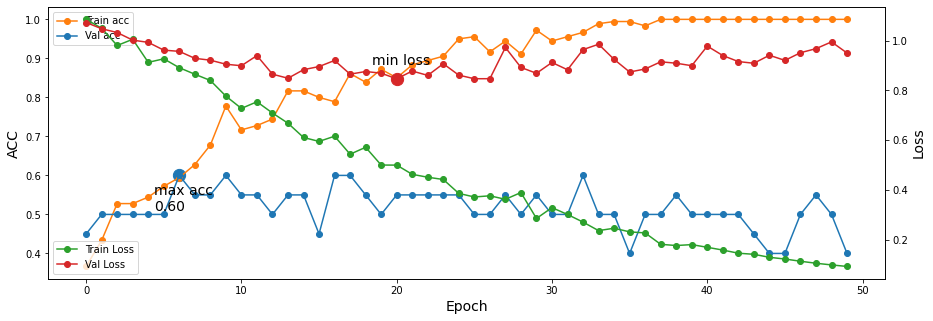

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 13s 291ms/step - loss: 1.0571 - accuracy: 0.4500 - val_loss: 1.0889 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0078 - accuracy: 0.5056 - val_loss: 1.0677 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9779 - accuracy: 0.5722 - val_loss: 1.0644 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9378 - accuracy: 0.6556 - val_loss: 1.0622 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9277 - accuracy: 0.5667 - val_loss: 1.0589 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8833 - accuracy: 0.6222 - val_loss: 1.0961 - val_accuracy: 0.3000
Epoch 7/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8175 - accuracy: 0.6278 - val_loss: 1.0823 - val

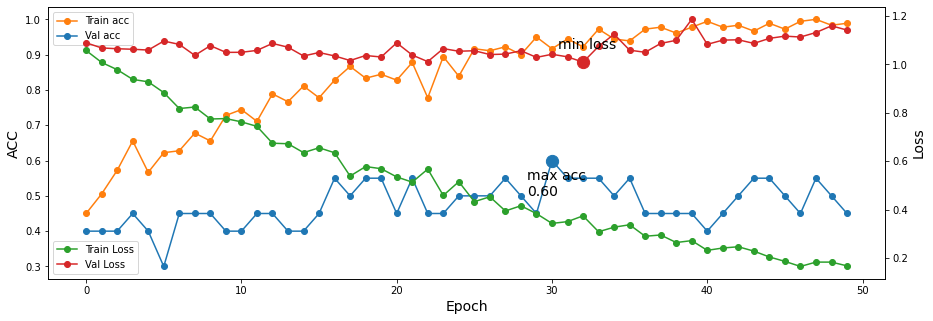

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 13s 293ms/step - loss: 1.0266 - accuracy: 0.4500 - val_loss: 1.0633 - val_accuracy: 0.3500
Epoch 2/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9753 - accuracy: 0.5389 - val_loss: 1.0133 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 4s 92ms/step - loss: 0.9103 - accuracy: 0.5333 - val_loss: 0.9989 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8790 - accuracy: 0.6111 - val_loss: 0.9676 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 4s 92ms/step - loss: 0.8415 - accuracy: 0.6000 - val_loss: 0.9749 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.8287 - accuracy: 0.6611 - val_loss: 1.0335 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.7692 - accuracy: 0.6667 - val_loss: 0.9356 - val

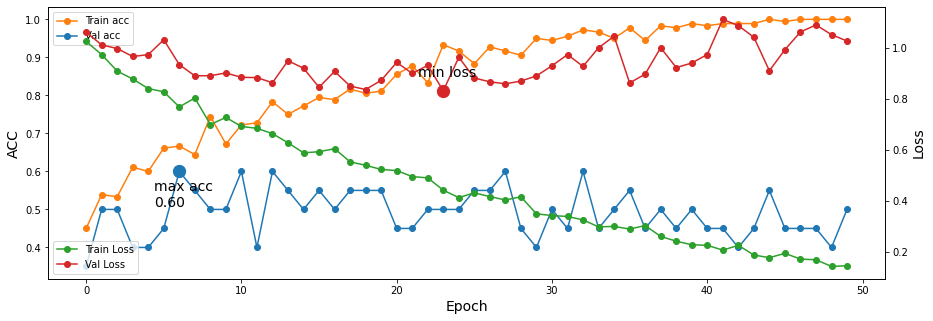

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 14s 316ms/step - loss: 1.0651 - accuracy: 0.4833 - val_loss: 1.0874 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0525 - accuracy: 0.4667 - val_loss: 1.0733 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0611 - accuracy: 0.4167 - val_loss: 1.0625 - val_accuracy: 0.4211
Epoch 4/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0283 - accuracy: 0.4611 - val_loss: 1.0568 - val_accuracy: 0.4211
Epoch 5/50
45/45 [==============================] - 4s 93ms/step - loss: 1.0111 - accuracy: 0.4778 - val_loss: 1.0383 - val_accuracy: 0.4211
Epoch 6/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9839 - accuracy: 0.4889 - val_loss: 1.0150 - val_accuracy: 0.4737
Epoch 7/50
45/45 [==============================] - 4s 93ms/step - loss: 0.9911 - accuracy: 0.5111 - val_loss: 1.0063 - va

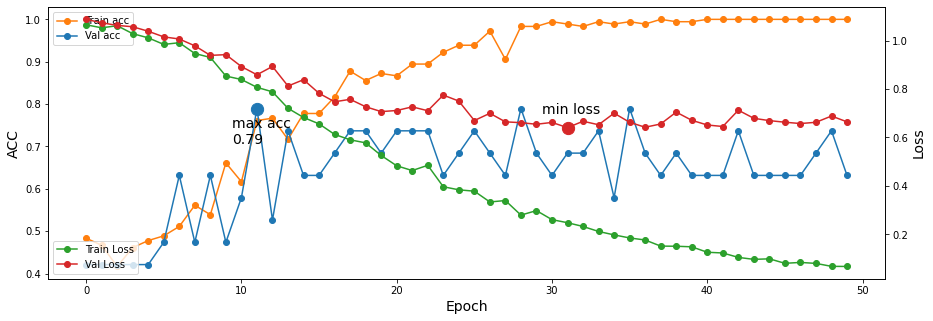

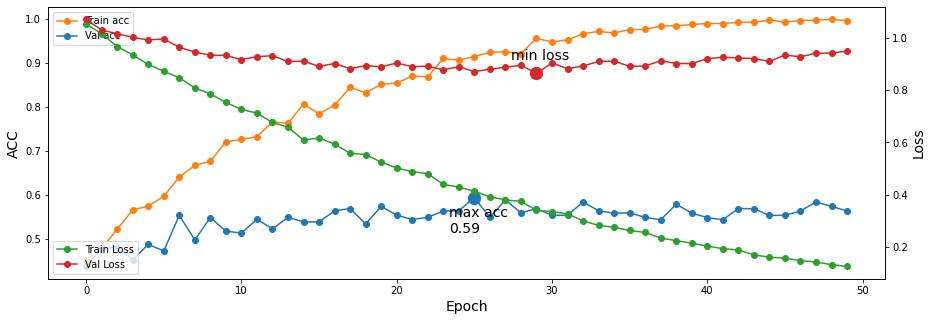

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.18260103464126587 - accuracy: 0.9777777791023254 - val_loss.: 0.891955554485321 - val_accuracy: 0.6000000238418579
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.10725706815719604 - accuracy: 1.0 - val_loss.: 1.181537389755249 - val_accuracy: 0.699999988079071
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.0862216204404831 - accuracy: 1.0 - val_loss.: 0.8533759117126465 - val_accuracy: 0.6000000238418579
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.16865864396095276 - accuracy: 0.9888888597488403 - val_loss.: 1.0113177299499512 - val_accuracy: 0.5
--------------------------------------------------------------------------------
> Fold

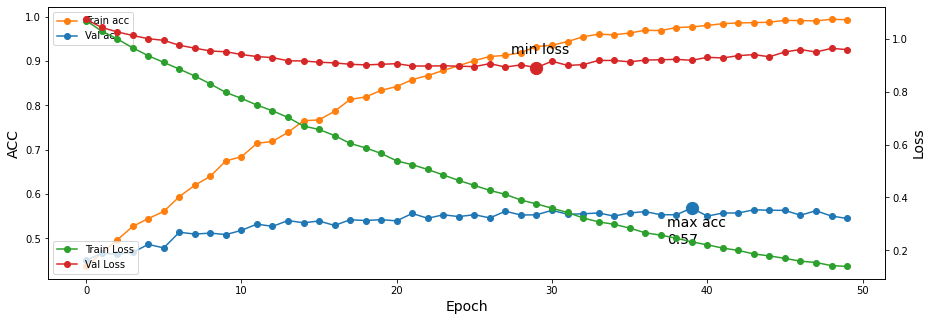

--------------------------------------------------------------------------------
Results per repetition (on last epoch)
--------------------------------------------------------------------------------
> Repetition 1 - Loss: 0.9670243203639984 - Accuracy : 0.5428947389125824
--------------------------------------------------------------------------------
> Repetition 2 - Loss: 0.9509215831756592 - Accuracy : 0.5728947401046753
--------------------------------------------------------------------------------
> Repetition 3 - Loss: 0.9748843848705292 - Accuracy : 0.49763157963752747
--------------------------------------------------------------------------------
> Repetition 4 - Loss: 0.9537674903869628 - Accuracy : 0.5481578916311264
--------------------------------------------------------------------------------
> Repetition 5 - Loss: 0.9490449011325837 - Accuracy : 0.5631578952074051
--------------------------------------------------------------------------------
Average results over re

In [66]:
select_dataset(2) # Standarized

metadata_train = pd.read_csv(METADATA_PATH + DS + '/train/train_summary.csv', encoding='utf-8')
metadata_test = pd.read_csv(METADATA_PATH + DS + '/test/test_summary.csv', encoding='utf-8')

X_train = DS_PATH + '/train/' + metadata_train.iloc[:, 0].to_numpy()
y_train = np.argmax(metadata_train.iloc[:,-len(CLASSES):].to_numpy(), axis=1)
X_test = DS_PATH + '/test/' + metadata_test.iloc[:, 0].to_numpy()
y_test = np.argmax(metadata_test.iloc[:,-len(CLASSES):].to_numpy(), axis=1)

# # =============================================================================
# # Train and test model 2 (and save results)
# # =============================================================================
# # Select hyperparameters
# LR = 0.00001 #, 0.00008
# BATCH_SIZE = 4 #, 64
# EPOCHS = 50

# test_model_rkfold(build_model_2, 'pet-spatialnorm-elastic-standarized_model-2_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-standarized_model-2_results.txt')
# model = train_model(build_model_2)
# # model = tf.keras.models.load_model('pet-spatialnorm-elastic-standarized_model-2.h5') # Not used
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-2.h5')

# # =============================================================================
# # Train and test model 0 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_0, 'pet-spatialnorm-elastic-standarized_model-0_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-standarized_model-0_results.txt')
# model = train_model(build_model_0)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-0.h5')

# # =============================================================================
# # Train and test model 1 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_1, 'pet-spatialnorm-elastic-standarized_model-1_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-standarized_model-1_results.txt')
# model = train_model(build_model_1)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-1.h5')


# ====================== Deeper model ======================

LR = 0.00001
BATCH_SIZE = 4
EPOCHS = 50

test_model_rkfold(build_model_3, 'pet-spatialnorm-elastic-standarized_model-1_results.txt')
show_rkfold_results('pet-spatialnorm-elastic-standarized_model-1_results.txt')
# model = train_model(build_model_1)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-1.h5')


# K-fold results visualization

In [ ]:
if tf.io.gfile.exists('Alzheimer-disease-classification'):
    shutil.rmtree('Alzheimer-disease-classification')
! git clone https://github.com/Angelvj/Alzheimer-disease-classification.git

results_path = 'Alzheimer-disease-classification/kfold_results/'

EPOCHS = 50
REPS = 5

# Model 0 results
print(' ===================== Results for model 0 =====================')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic_model-0_results.txt')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic-maxintensitynorm_model-0_results.txt')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-standarized_model-2_results.txt') TODO

# Model 1 results
print(' ===================== Results for model 1 =====================')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic_model-1_results.txt')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic-maxintensitynorm_model-1_results.txt')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-standarized_model-2_results.txt') TODO

# Model 2 results
print(' ===================== Results for model 2 =====================')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic_model-2_results.txt')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic-maxintensitynorm_model-2_results.txt')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic-standarized_model-2_results.txt')